In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [2]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


In [5]:
print(data.files)

['training_set_filtered', 'masks_filtered', 'test_set']


In [6]:
X_train_images = np.array([x.reshape(64, 128) for x in X_train])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train])


In [7]:
X_val_images = np.array([x.reshape(64, 128) for x in X_val])
y_val_masks = np.array([y.reshape(64, 128) for y in y_val])

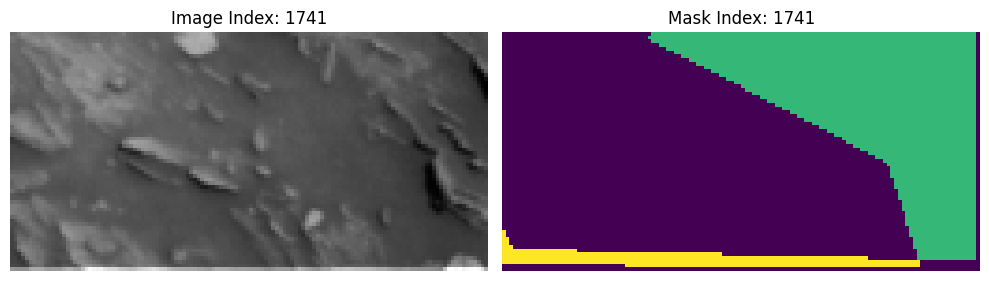

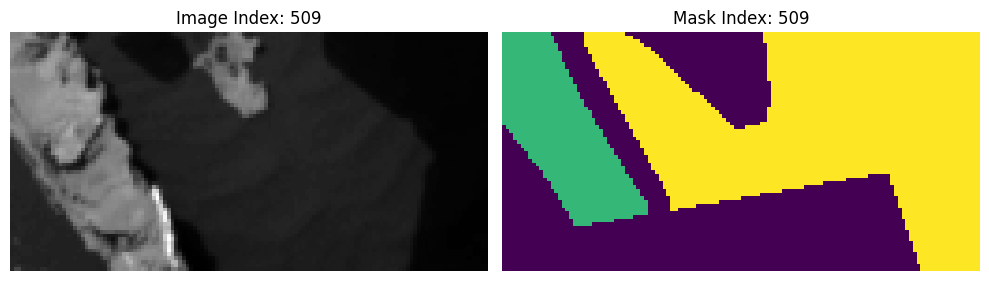

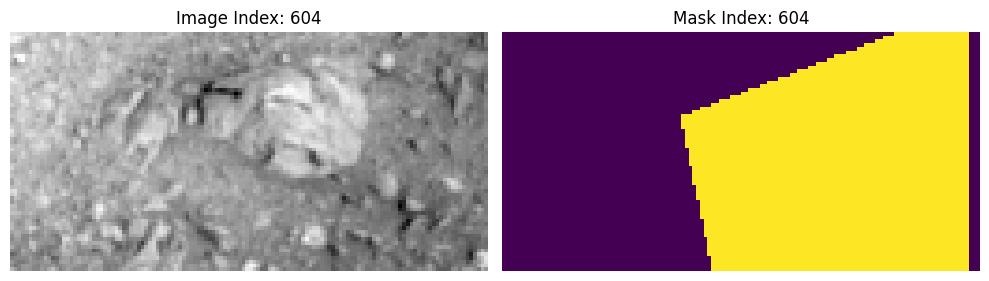

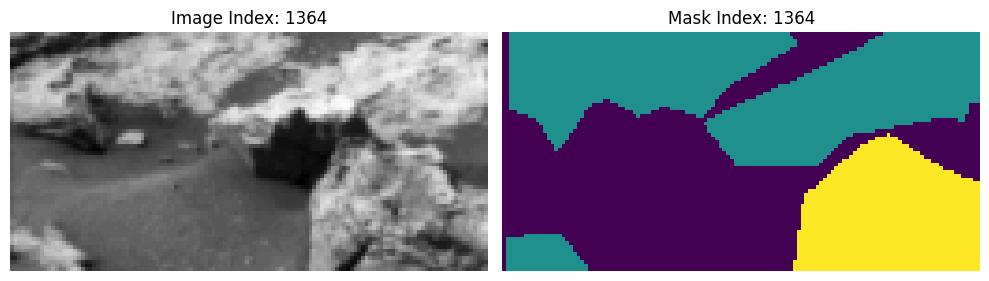

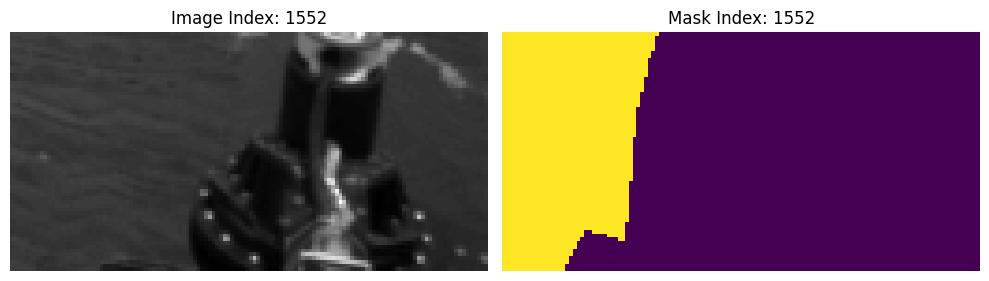

In [8]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## TRAIN

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2004, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (2004, 64, 128)


In [11]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

In [12]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (2004, 64, 128, 1)
Shape of y_train after reshaping: (2004, 64, 128, 1)


In [13]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [14]:
# Check normalization for training images
print("Image Data Statistics:")
print(f"Min value in X_train: {X_train.min()}")
print(f"Max value in X_train: {X_train.max()}")
print(f"Unique values in X_train: {np.unique(X_train[:10])}")  # Check for unique pixel values in the first 10 samples

# Check statistics for training masks
print("\nMask Data Statistics:")
print(f"Min value in y_train: {y_train.min()}")
print(f"Max value in y_train: {y_train.max()}")
print(f"Unique values in y_train: {np.unique(y_train[:10])}")  # Check for unique mask labels in the first 10 samples


Image Data Statistics:
Min value in X_train: 0.011764705882352941
Max value in X_train: 0.996078431372549
Unique values in X_train: [0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549
 0.14117647 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431
 0.16470588 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.28235294 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078
 0.30588235 0.30980392 0.31372549 0.31764706 0.32156863 0.3254902

## DEEP LAB

In [15]:
import keras
from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.data import Dataset as tf_data

# Constants
IMAGE_HEIGHT = 64  # Image height
IMAGE_WIDTH = 128  # Image width
BATCH_SIZE = 32

def preprocess_image(image, is_mask=False):
    """
    Preprocess the image or mask:
    - Resize to desired size
    - Normalize only for images
    - Cast masks to integer type
    """
    if is_mask:
        # Resize masks and preserve integer class labels
        image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH], method='nearest')
        return tf.cast(image, tf.int32)  # Ensure masks are integers
    else:
        # Images are already normalized, only resize
        return tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])


def load_data(image, mask):
    """
    Load and preprocess a single image-mask pair.
    """
    image = preprocess_image(image, is_mask=False)
    mask = preprocess_image(mask, is_mask=True)
    return image, mask

def data_generator(images, masks):
    """
    Create a TensorFlow Dataset object from image and mask arrays.
    """
    dataset = tf_data.from_tensor_slices((images, masks))
    dataset = dataset.map(lambda img, msk: load_data(img, msk), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare train and validation datasets
train_dataset = data_generator(X_train, y_train)
val_dataset = data_generator(X_val, y_val)

# Debugging output to verify the datasets
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)


Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128, 1), dtype=tf.int32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 128, 1), dtype=tf.int32, name=None))>


In [17]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [18]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.framework import ops

from tensorflow.keras import layers
from tensorflow import keras

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    """
    A single convolutional block with BatchNormalization and ReLU activation.
    """
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.keras.activations.relu(x)  # Fixed activation function


def DilatedSpatialPyramidPooling(dspp_input):
    """
    Atrous Spatial Pyramid Pooling (ASPP) implementation.
    """
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    # Input Layer
    model_input = keras.Input(shape=(image_size[0], image_size[1], 1))  # Update for grayscale images

    # Backbone
    resnet50 = keras.applications.ResNet50(
        weights=None,  # No pre-trained weights
        include_top=False,
        input_tensor=model_input,
    )

    # Atrous Spatial Pyramid Pooling
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    # Upsample and merge with lower-level features
    input_a = layers.UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)

    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)

    # Final Upsampling
    x = layers.UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    # Output Layer
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


# Test the model
model = DeeplabV3Plus(image_size=(64, 128), num_classes=5)

model.summary()



# Instantiate the model
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 128
NUM_CLASSES = 5
model = DeeplabV3Plus(image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), num_classes=NUM_CLASSES)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,847,109 (45.19 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 11,847,109 (45.19 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [19]:
y_train = np.squeeze(y_train)  # Remove channel dimension if it exists
y_val = np.squeeze(y_val)

In [20]:
y_train.shape

(2004, 64, 128)

In [21]:
y_val.shape

(501, 64, 128)

In [22]:
def load_data(image, mask):
    """
    Load and preprocess a single image-mask pair.
    """
    image = preprocess_image(image, is_mask=False)
    mask = preprocess_image(mask, is_mask=True)
    mask = tf.squeeze(mask, axis=-1)  # Remove the channel dimension from masks
    return image, mask


In [23]:
for images, masks in train_dataset.take(1):
    print(f"Train Images Shape: {images.shape}")  # Should be (batch_size, 64, 128, 1)
    print(f"Train Masks Shape: {masks.shape}")    # Should be (batch_size, 64, 128)


Train Images Shape: (32, 64, 128, 1)
Train Masks Shape: (32, 64, 128, 1)


In [24]:
def load_data(image, mask):
    """
    Load and preprocess a single image-mask pair.
    """
    image = preprocess_image(image, is_mask=False)
    mask = preprocess_image(mask, is_mask=True)
    return image, mask

def data_generator(images, masks):
    """
    Create a TensorFlow Dataset object from image and mask arrays.
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


In [33]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)
# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=loss,
    metrics=["accuracy", mean_iou],
)



In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 11,847,109 (45.19 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [27]:
for img, msk in train_dataset.take(1):
    print(f"Image Shape: {img.shape}")
    print(f"Mask Shape: {msk.shape}")


Image Shape: (32, 64, 128, 1)
Mask Shape: (32, 64, 128, 1)


In [28]:
print("Unique values in y_train:", np.unique(y_train))


Unique values in y_train: [0. 1. 2. 3. 4.]


In [29]:
# Check the layers in your model for any operations that might be
# trying to access a channel index that is out of bounds.
# For example, if you have a convolutional layer with filters expecting
# more channels than your input provides, it could lead to this error.

# Example: If you have a layer like this:
# Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64, 128, 1))
# And later in the model you have a layer that expects 3 channels:
# Conv2D(filters=64, kernel_size=(3, 3), input_shape=(?, ?, 3))
# This would cause an error because your input only has 1 channel.

# To fix this, make sure the input channels of all layers are consistent
# with the actual number of channels in your input data.

# You can inspect your model's layers and their configurations using:
for layer in model.layers:
    # Check if the layer is an InputLayer before accessing input.shape
    if isinstance(layer, keras.layers.InputLayer):
        # If InputLayer has multiple inputs, it's a list, so iterate:
        if isinstance(layer.input, list):
            for input_tensor in layer.input:
                input_shape = input_tensor.shape
                print(layer.name, input_shape, layer.output_shape)
        else:  # Single input, access shape directly
            input_shape = layer.input.shape
            print(layer.name, input_shape, layer.output_shape)
    else:
        # For other layers, access the input shape via the 'input' attribute
        # and handle cases where input is a list (e.g., Concatenate layer)
        if isinstance(layer.input, list):
            # If the layer has multiple inputs, print the shape of each input
            for i, input_tensor in enumerate(layer.input):
                input_shape = input_tensor.shape
                print(f"{layer.name} (Input {i + 1})", input_shape) # Removed layer.output_shape
        else:
            input_shape = layer.input.shape
            print(layer.name, input_shape) # Removed layer.output_shape, printing input shape instead



# Look for inconsistencies in the expected input shapes and adjust
# the layers accordingly.

# If you're using any pre-trained models, ensure they are compatible
# with your input data's shape, or use appropriate preprocessing
# to adjust the input.

# Example: To change the input channels of a Conv2D layer:
# problematic_layer = model.get_layer(name='problematic_layer_name')
# problematic_layer.input_shape = (None, 64, 128, 1)  # Adjust as needed

conv1_pad (None, 64, 128, 1)
conv1_conv (None, 70, 134, 1)
conv1_bn (None, 32, 64, 64)
conv1_relu (None, 32, 64, 64)
pool1_pad (None, 32, 64, 64)
pool1_pool (None, 34, 66, 64)
conv2_block1_1_conv (None, 16, 32, 64)
conv2_block1_1_bn (None, 16, 32, 64)
conv2_block1_1_relu (None, 16, 32, 64)
conv2_block1_2_conv (None, 16, 32, 64)
conv2_block1_2_bn (None, 16, 32, 64)
conv2_block1_2_relu (None, 16, 32, 64)
conv2_block1_0_conv (None, 16, 32, 64)
conv2_block1_3_conv (None, 16, 32, 64)
conv2_block1_0_bn (None, 16, 32, 256)
conv2_block1_3_bn (None, 16, 32, 256)
conv2_block1_add (Input 1) (None, 16, 32, 256)
conv2_block1_add (Input 2) (None, 16, 32, 256)
conv2_block1_out (None, 16, 32, 256)
conv2_block2_1_conv (None, 16, 32, 256)
conv2_block2_1_bn (None, 16, 32, 64)
conv2_block2_1_relu (None, 16, 32, 64)
conv2_block2_2_conv (None, 16, 32, 64)
conv2_block2_2_bn (None, 16, 32, 64)
conv2_block2_2_relu (None, 16, 32, 64)
conv2_block2_3_conv (None, 16, 32, 64)
conv2_block2_3_bn (None, 16, 32, 256)
c

In [31]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

Epoch 1/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6768 - loss: 0.8395 - mean_io_u: 0.3890
Epoch 1: val_loss improved from inf to 5.08173, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


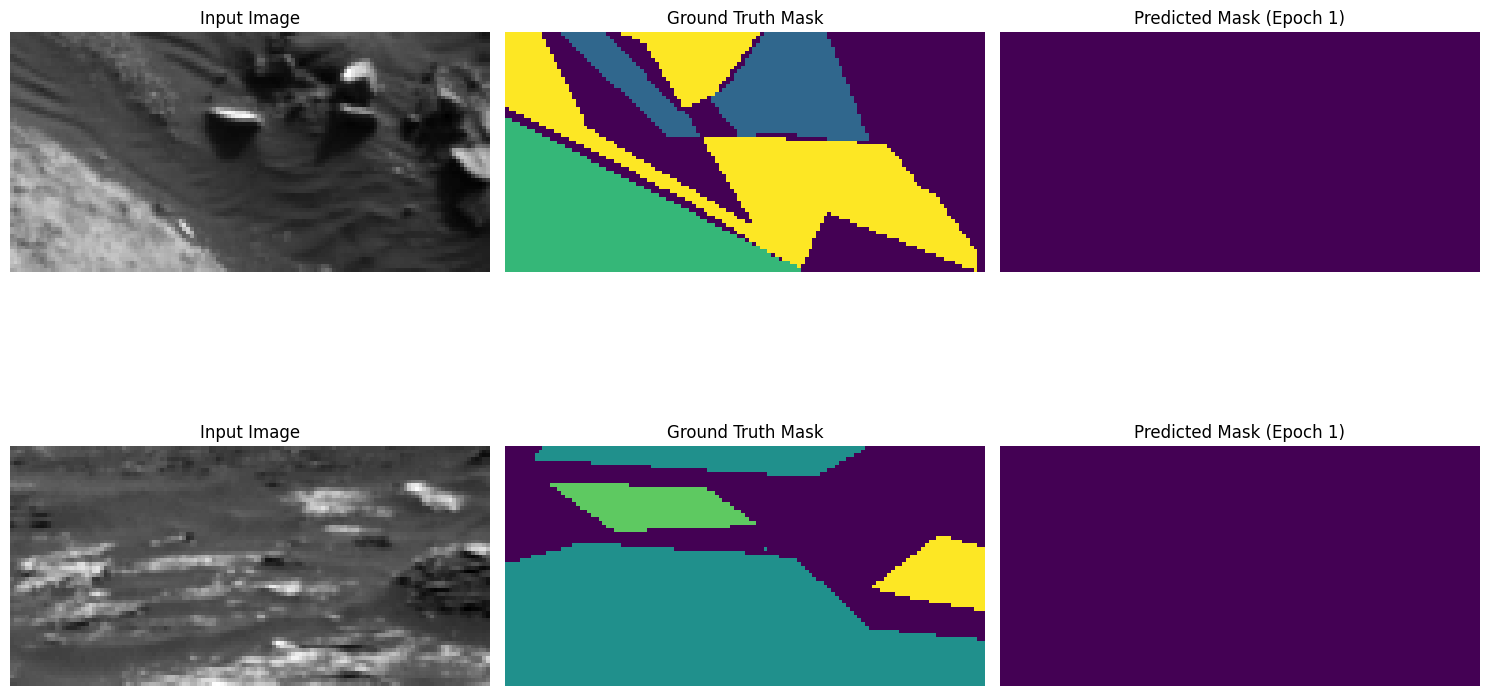

63/63 ━━━━━━━━━━━━━━━━━━━━ 107s 766ms/step - accuracy: 0.6769 - loss: 0.8390 - mean_io_u: 0.3890 - val_accuracy: 0.1983 - val_loss: 5.0817 - val_mean_io_u: 0.0524 - learning_rate: 1.0000e-04
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7046 - loss: 0.7730 - mean_io_u: 0.4100
Epoch 2: val_loss improved from 5.08173 to 4.27579, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


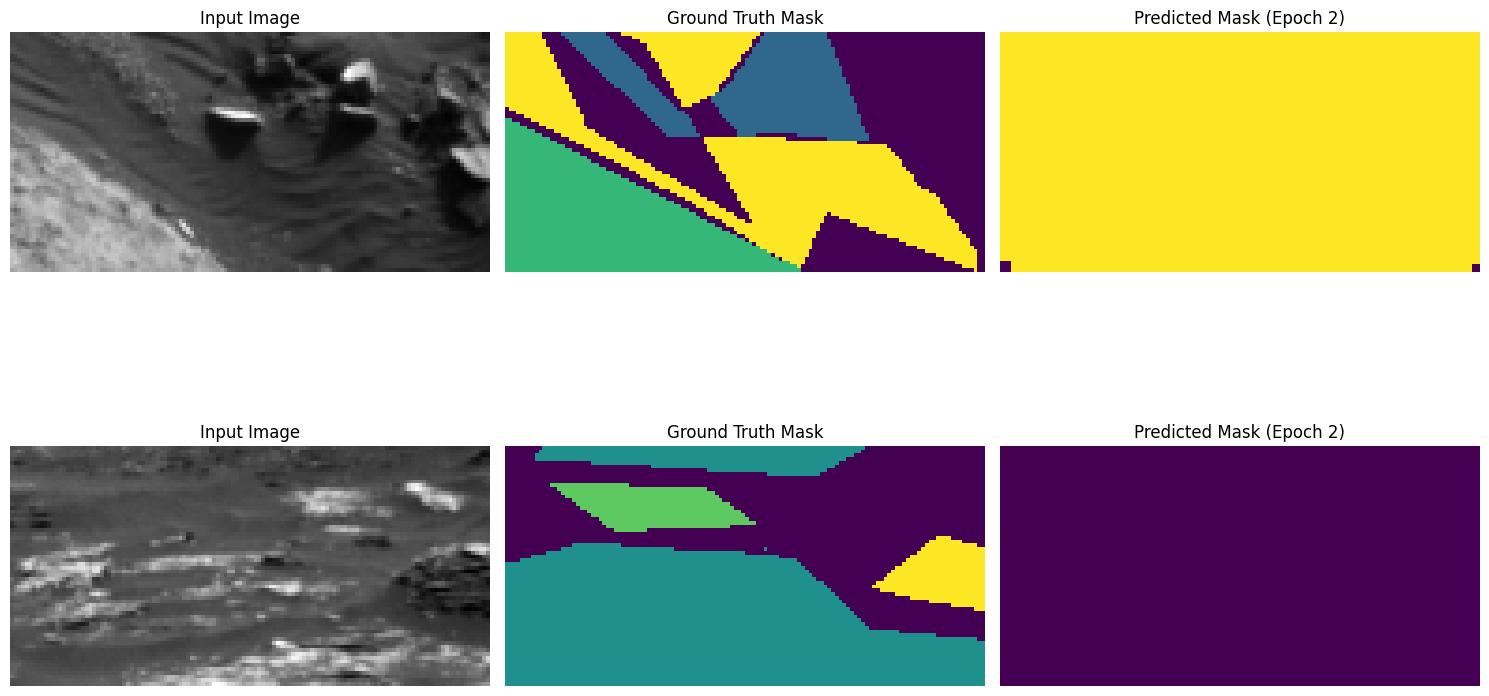

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.7045 - loss: 0.7730 - mean_io_u: 0.4098 - val_accuracy: 0.1989 - val_loss: 4.2758 - val_mean_io_u: 0.0520 - learning_rate: 1.0000e-04
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7093 - loss: 0.7579 - mean_io_u: 0.4098
Epoch 3: val_loss did not improve from 4.27579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


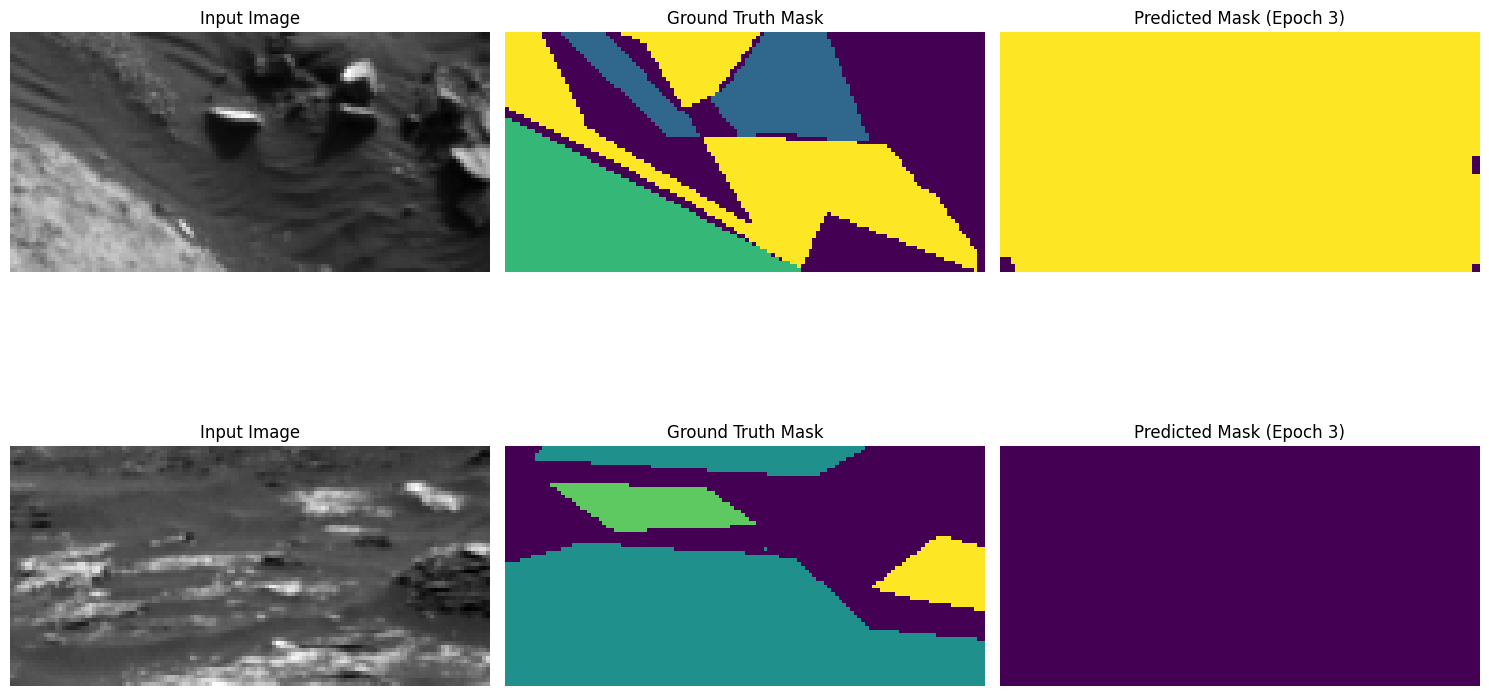

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.7093 - loss: 0.7576 - mean_io_u: 0.4098 - val_accuracy: 0.1997 - val_loss: 4.2964 - val_mean_io_u: 0.0517 - learning_rate: 1.0000e-04
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7050 - loss: 0.7587 - mean_io_u: 0.4039
Epoch 4: val_loss improved from 4.27579 to 4.18588, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


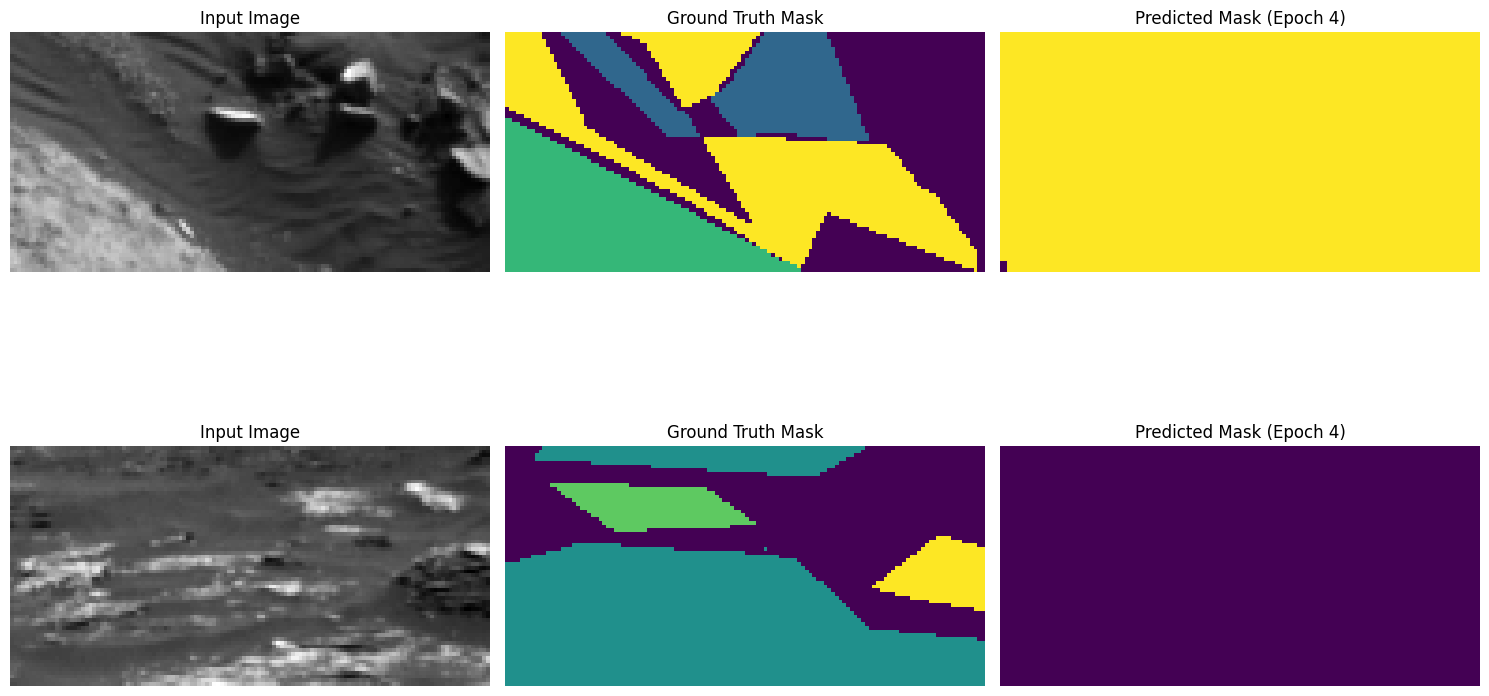

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.7052 - loss: 0.7583 - mean_io_u: 0.4039 - val_accuracy: 0.1996 - val_loss: 4.1859 - val_mean_io_u: 0.0519 - learning_rate: 1.0000e-04
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7246 - loss: 0.7239 - mean_io_u: 0.4204
Epoch 5: val_loss improved from 4.18588 to 3.48510, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


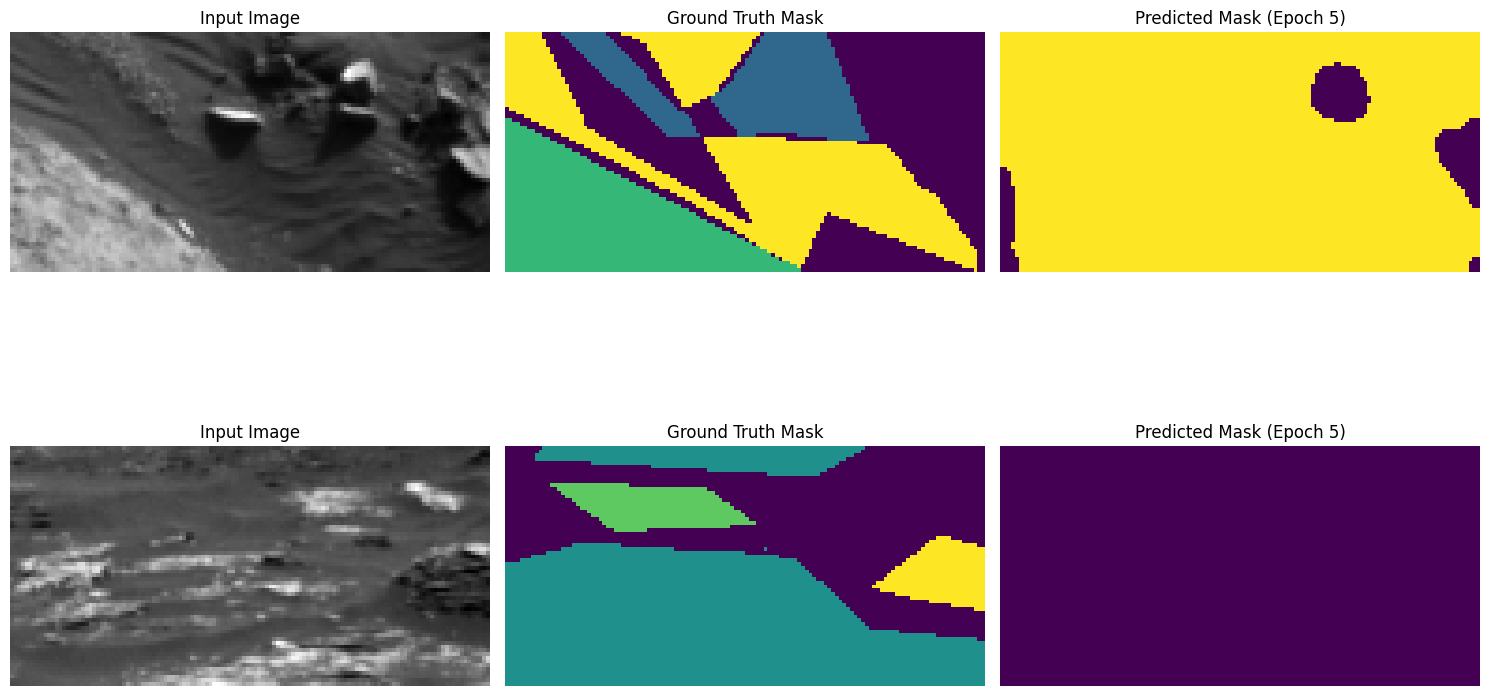

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.7247 - loss: 0.7237 - mean_io_u: 0.4205 - val_accuracy: 0.2223 - val_loss: 3.4851 - val_mean_io_u: 0.0611 - learning_rate: 1.0000e-04
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7404 - loss: 0.6853 - mean_io_u: 0.4359
Epoch 6: val_loss improved from 3.48510 to 3.07732, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


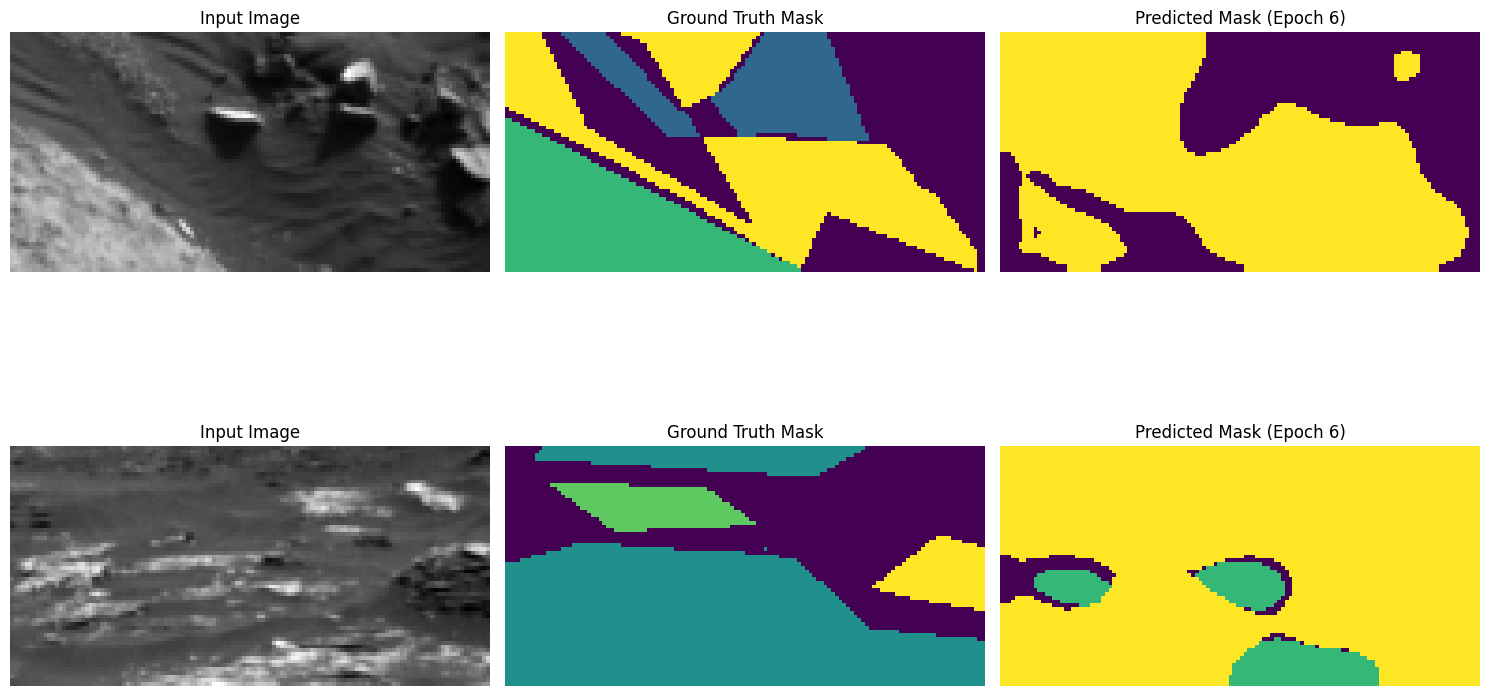

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.7405 - loss: 0.6849 - mean_io_u: 0.4359 - val_accuracy: 0.2692 - val_loss: 3.0773 - val_mean_io_u: 0.0792 - learning_rate: 1.0000e-04
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7642 - loss: 0.6323 - mean_io_u: 0.4556
Epoch 7: val_loss improved from 3.07732 to 2.15902, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


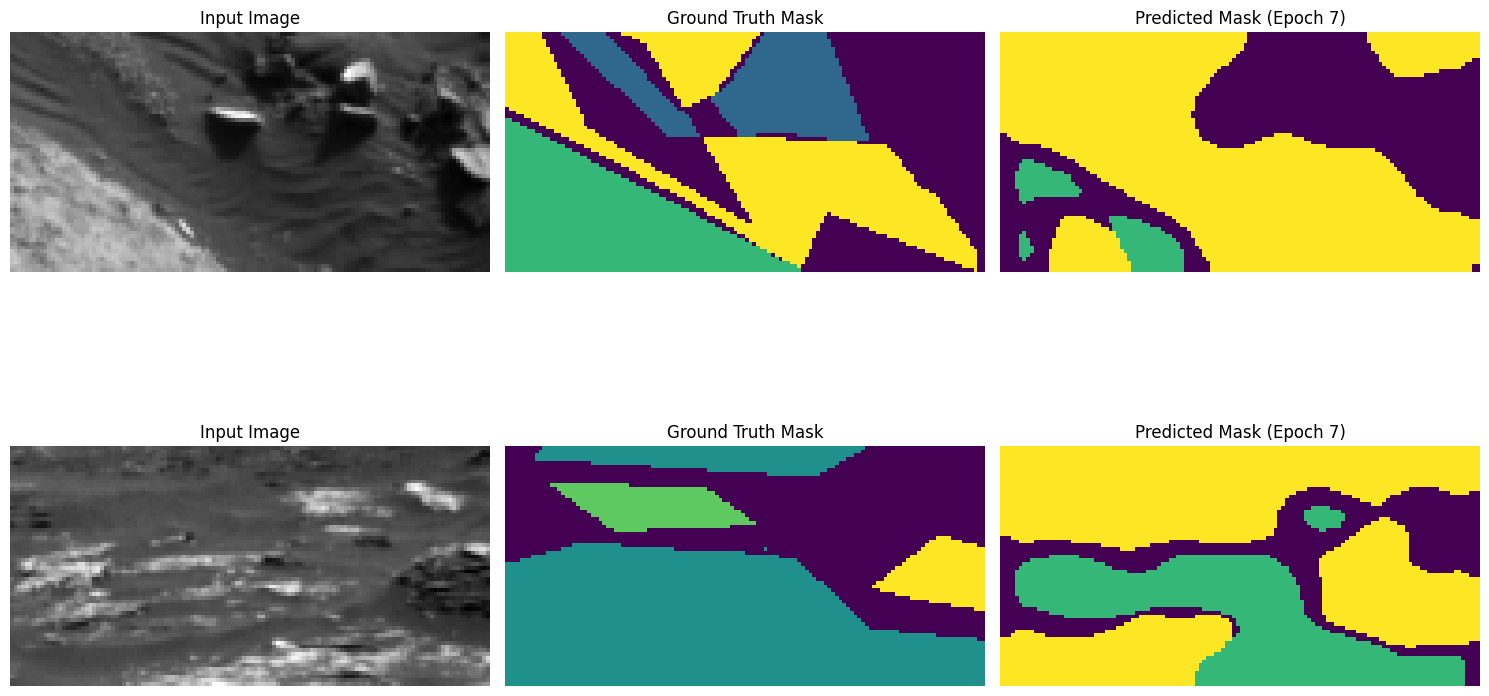

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.7642 - loss: 0.6322 - mean_io_u: 0.4555 - val_accuracy: 0.3671 - val_loss: 2.1590 - val_mean_io_u: 0.1414 - learning_rate: 1.0000e-04
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7765 - loss: 0.6048 - mean_io_u: 0.4645
Epoch 8: val_loss improved from 2.15902 to 1.76415, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


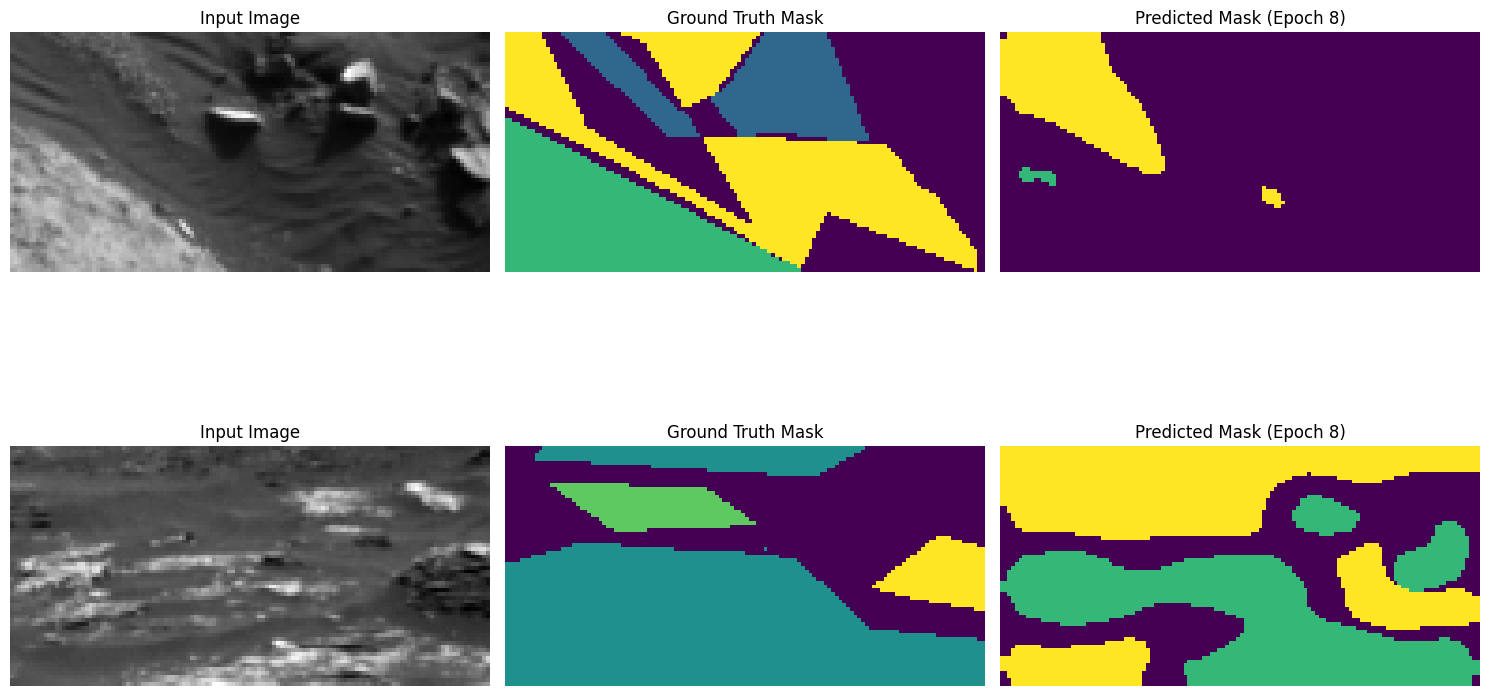

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.7764 - loss: 0.6048 - mean_io_u: 0.4643 - val_accuracy: 0.4339 - val_loss: 1.7642 - val_mean_io_u: 0.1809 - learning_rate: 1.0000e-04
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7820 - loss: 0.5920 - mean_io_u: 0.4692
Epoch 9: val_loss improved from 1.76415 to 1.08894, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


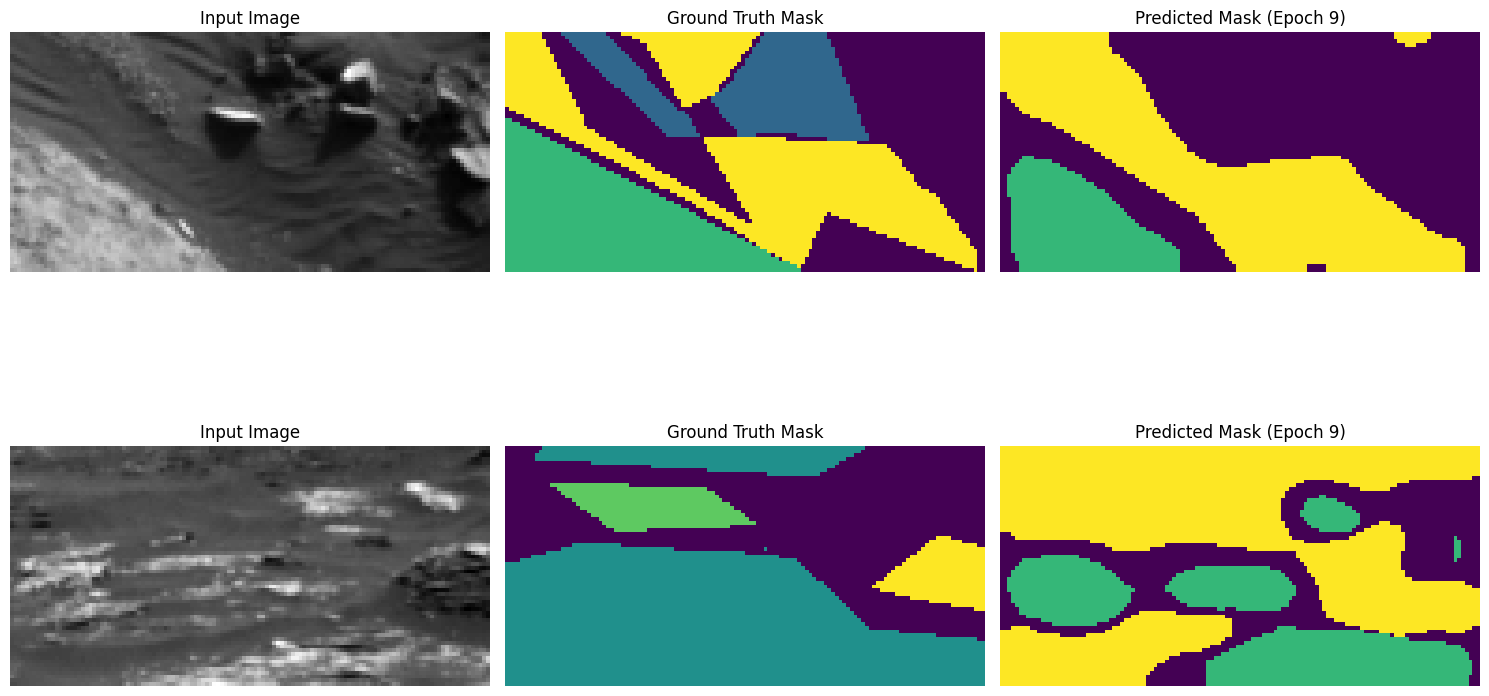

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.7820 - loss: 0.5918 - mean_io_u: 0.4691 - val_accuracy: 0.6174 - val_loss: 1.0889 - val_mean_io_u: 0.3383 - learning_rate: 1.0000e-04
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7856 - loss: 0.5688 - mean_io_u: 0.4614
Epoch 10: val_loss improved from 1.08894 to 1.01117, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


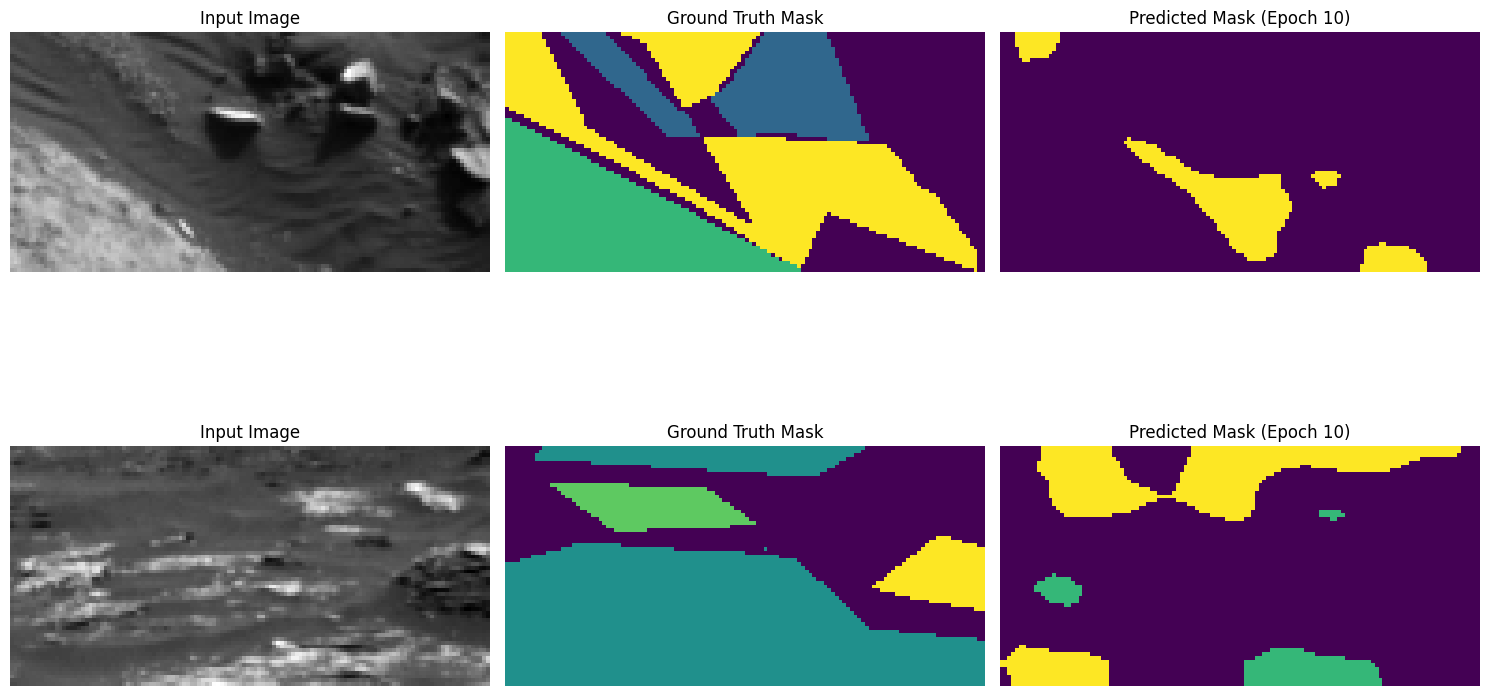

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.7856 - loss: 0.5689 - mean_io_u: 0.4613 - val_accuracy: 0.6172 - val_loss: 1.0112 - val_mean_io_u: 0.3012 - learning_rate: 1.0000e-04
Epoch 11/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7939 - loss: 0.5482 - mean_io_u: 0.4750
Epoch 11: val_loss did not improve from 1.01117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


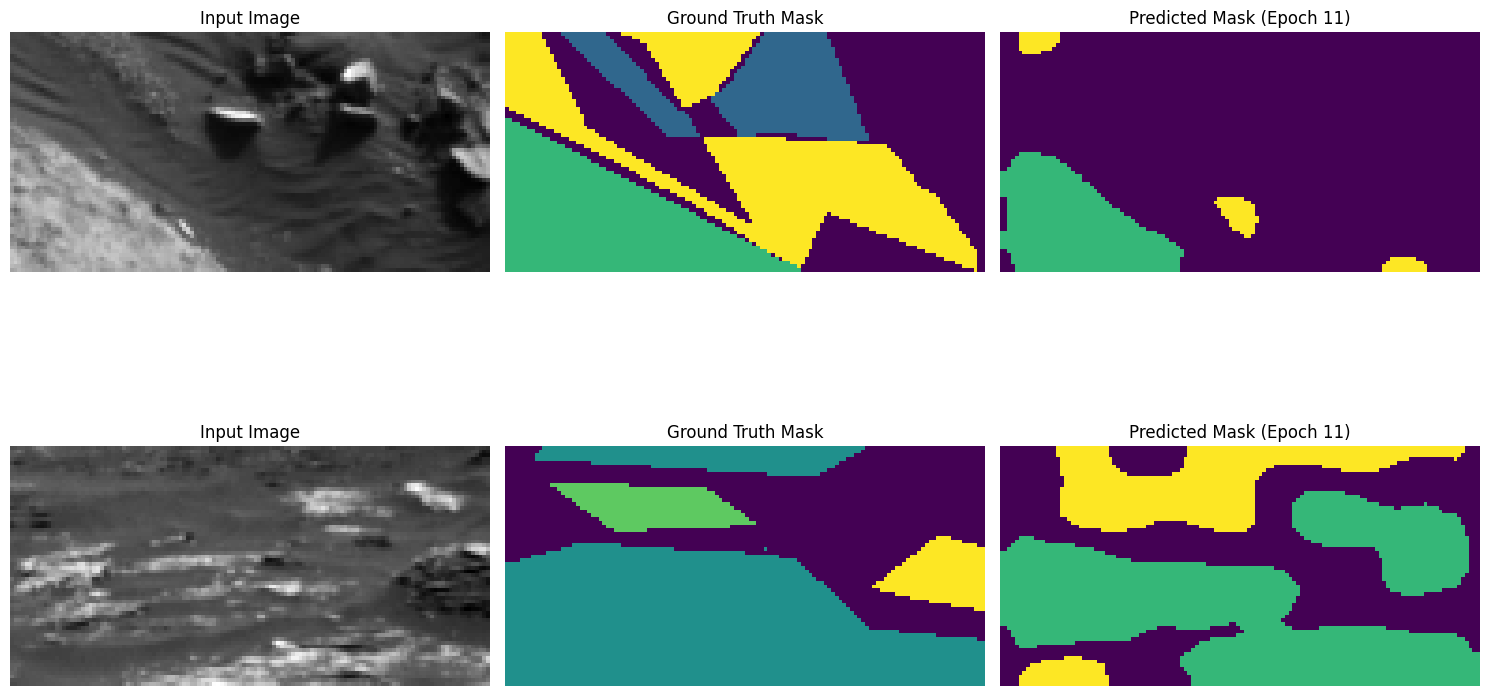

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.7939 - loss: 0.5482 - mean_io_u: 0.4748 - val_accuracy: 0.5770 - val_loss: 1.2067 - val_mean_io_u: 0.3043 - learning_rate: 1.0000e-04
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8053 - loss: 0.5104 - mean_io_u: 0.4962
Epoch 12: val_loss improved from 1.01117 to 0.99830, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


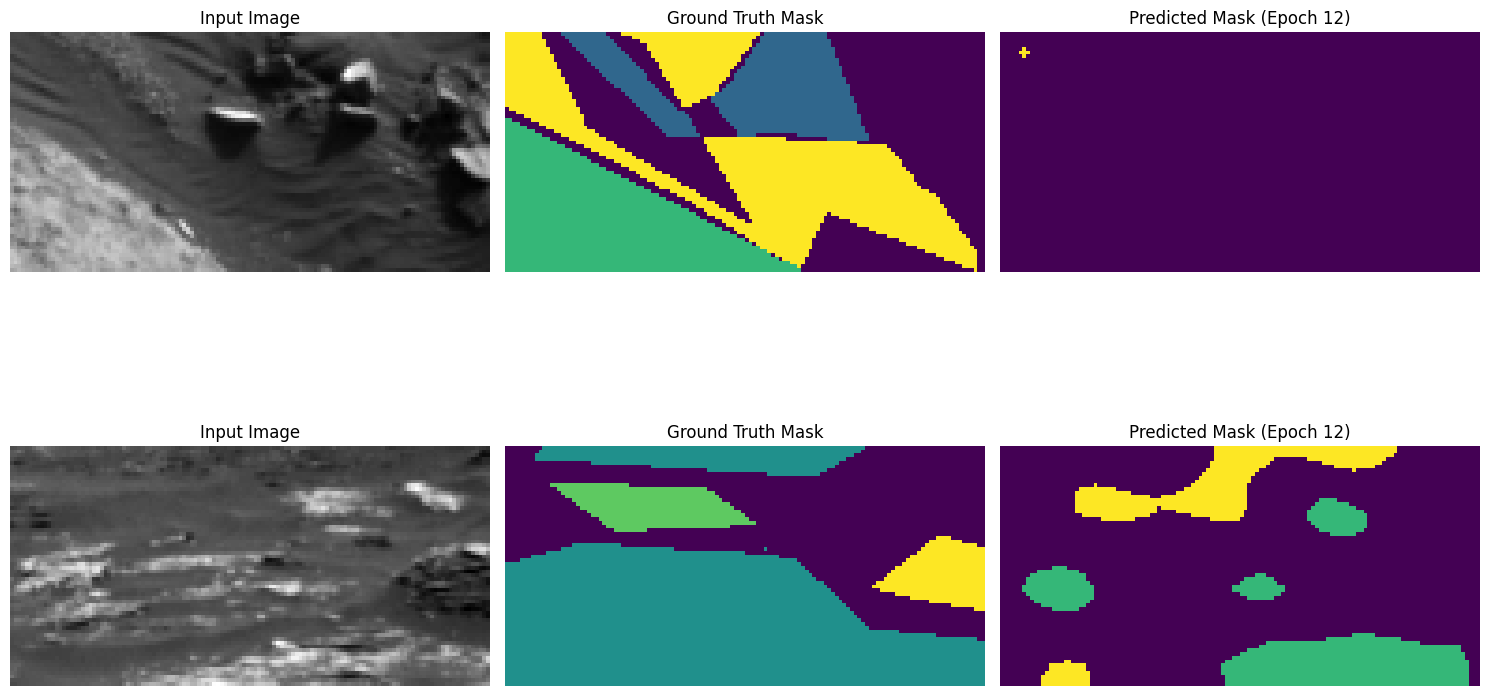

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.8053 - loss: 0.5104 - mean_io_u: 0.4961 - val_accuracy: 0.6488 - val_loss: 0.9983 - val_mean_io_u: 0.3198 - learning_rate: 1.0000e-04
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8132 - loss: 0.5031 - mean_io_u: 0.5140
Epoch 13: val_loss did not improve from 0.99830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


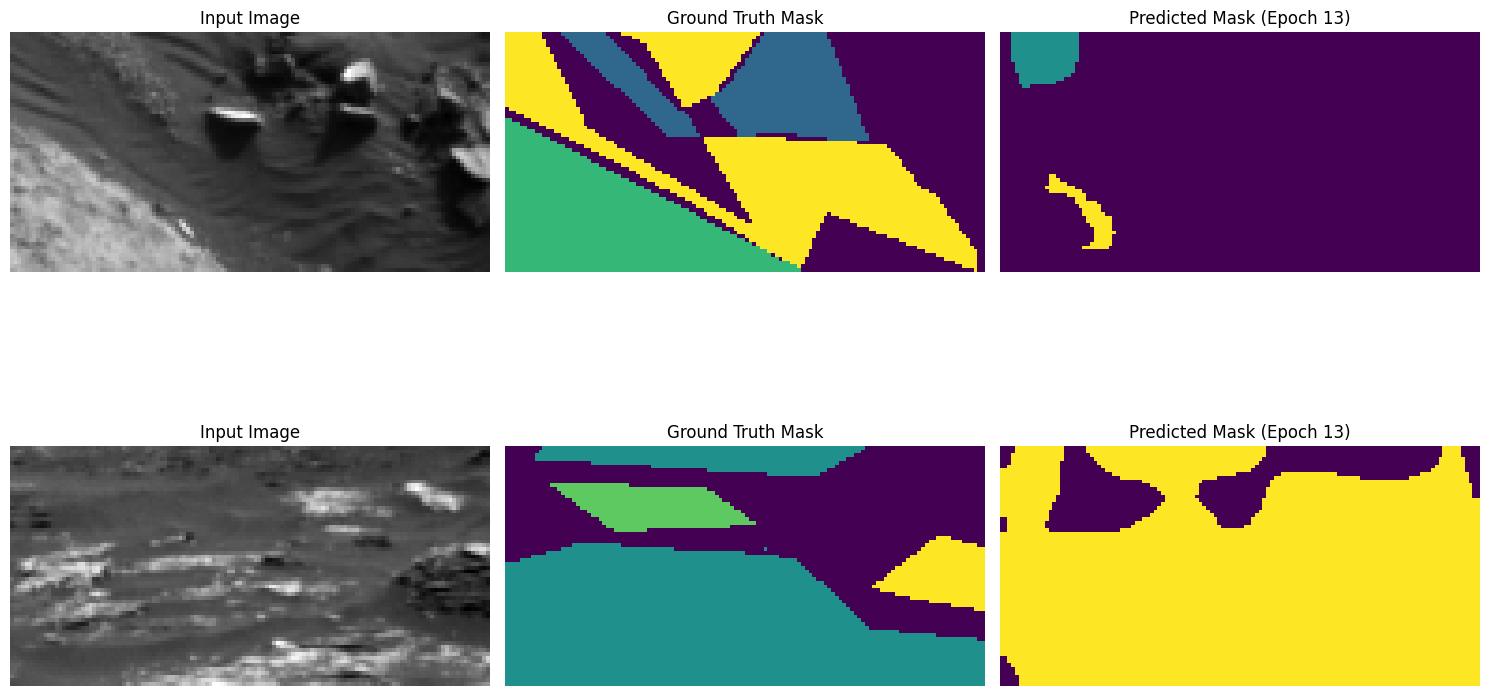

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.8133 - loss: 0.5030 - mean_io_u: 0.5138 - val_accuracy: 0.6211 - val_loss: 1.0569 - val_mean_io_u: 0.2980 - learning_rate: 1.0000e-04
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8233 - loss: 0.4780 - mean_io_u: 0.4958
Epoch 14: val_loss did not improve from 0.99830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


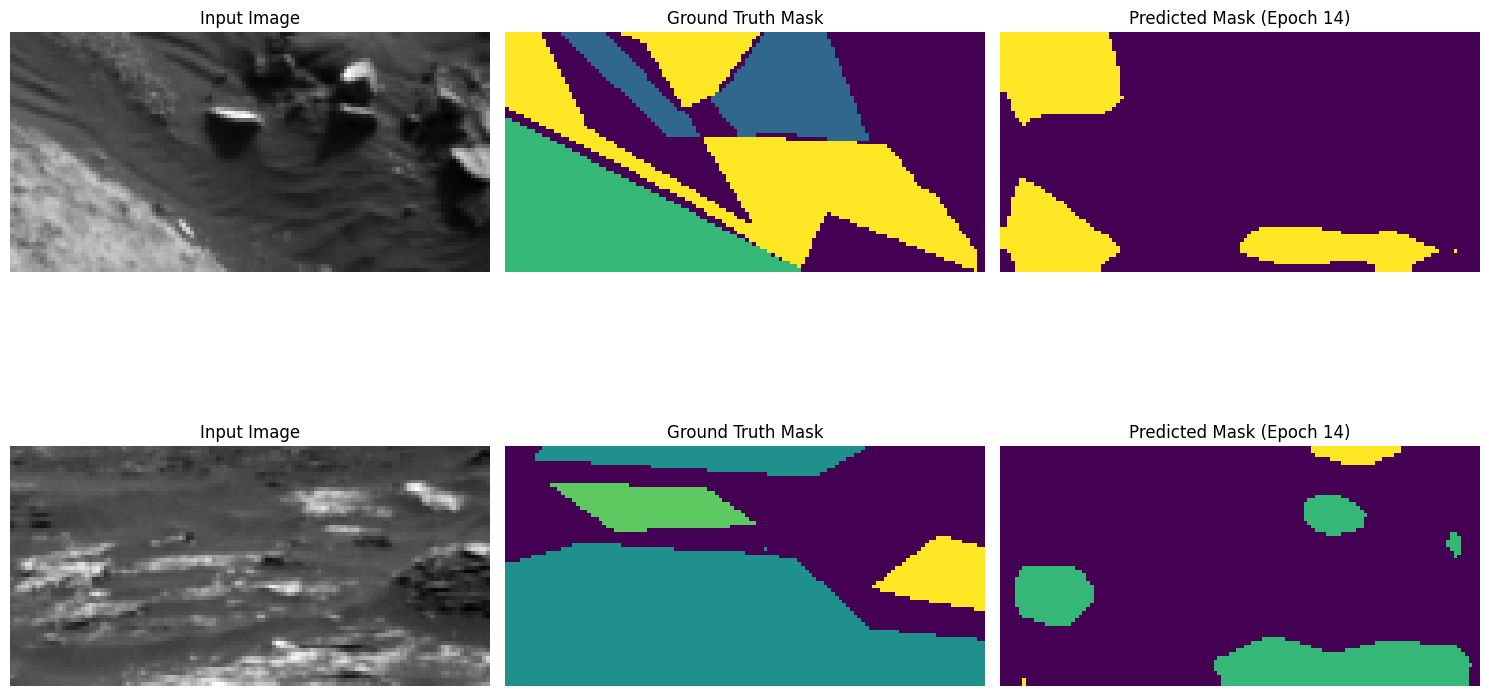

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.8234 - loss: 0.4780 - mean_io_u: 0.4957 - val_accuracy: 0.5259 - val_loss: 1.6016 - val_mean_io_u: 0.1768 - learning_rate: 1.0000e-04
Epoch 15/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8377 - loss: 0.4492 - mean_io_u: 0.5271
Epoch 15: val_loss did not improve from 0.99830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


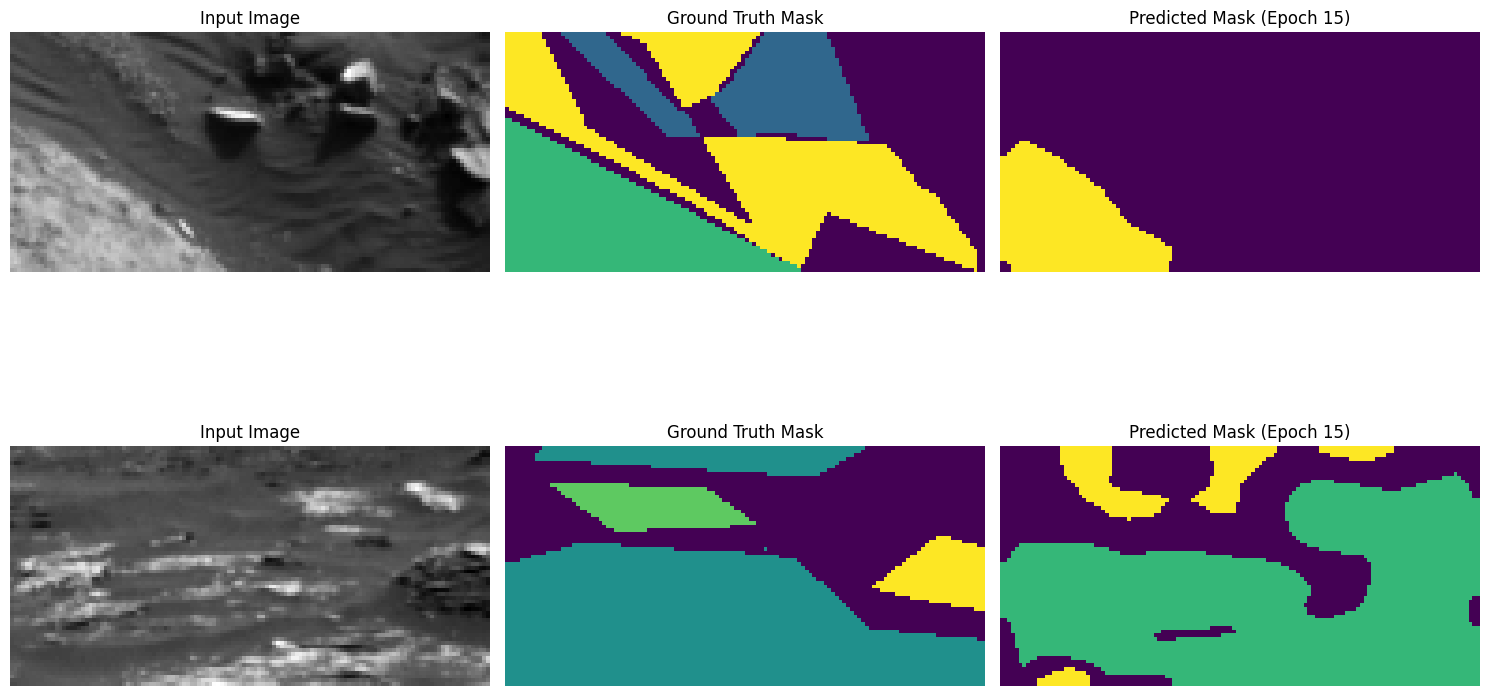

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.8377 - loss: 0.4493 - mean_io_u: 0.5269 - val_accuracy: 0.6207 - val_loss: 1.2204 - val_mean_io_u: 0.3022 - learning_rate: 1.0000e-04
Epoch 16/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8307 - loss: 0.4491 - mean_io_u: 0.5094
Epoch 16: val_loss did not improve from 0.99830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


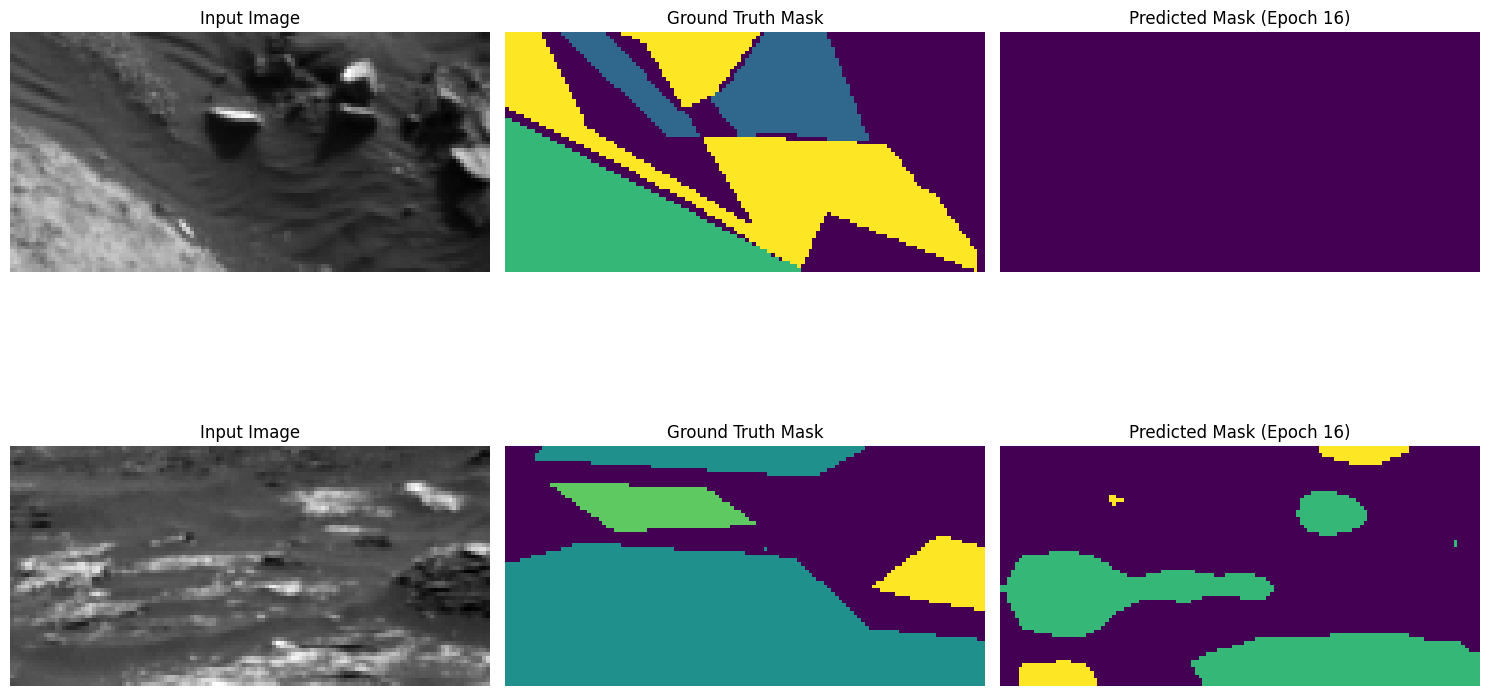

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.8307 - loss: 0.4492 - mean_io_u: 0.5093 - val_accuracy: 0.5950 - val_loss: 1.2454 - val_mean_io_u: 0.2495 - learning_rate: 1.0000e-04
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8354 - loss: 0.4361 - mean_io_u: 0.5155
Epoch 17: val_loss did not improve from 0.99830

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


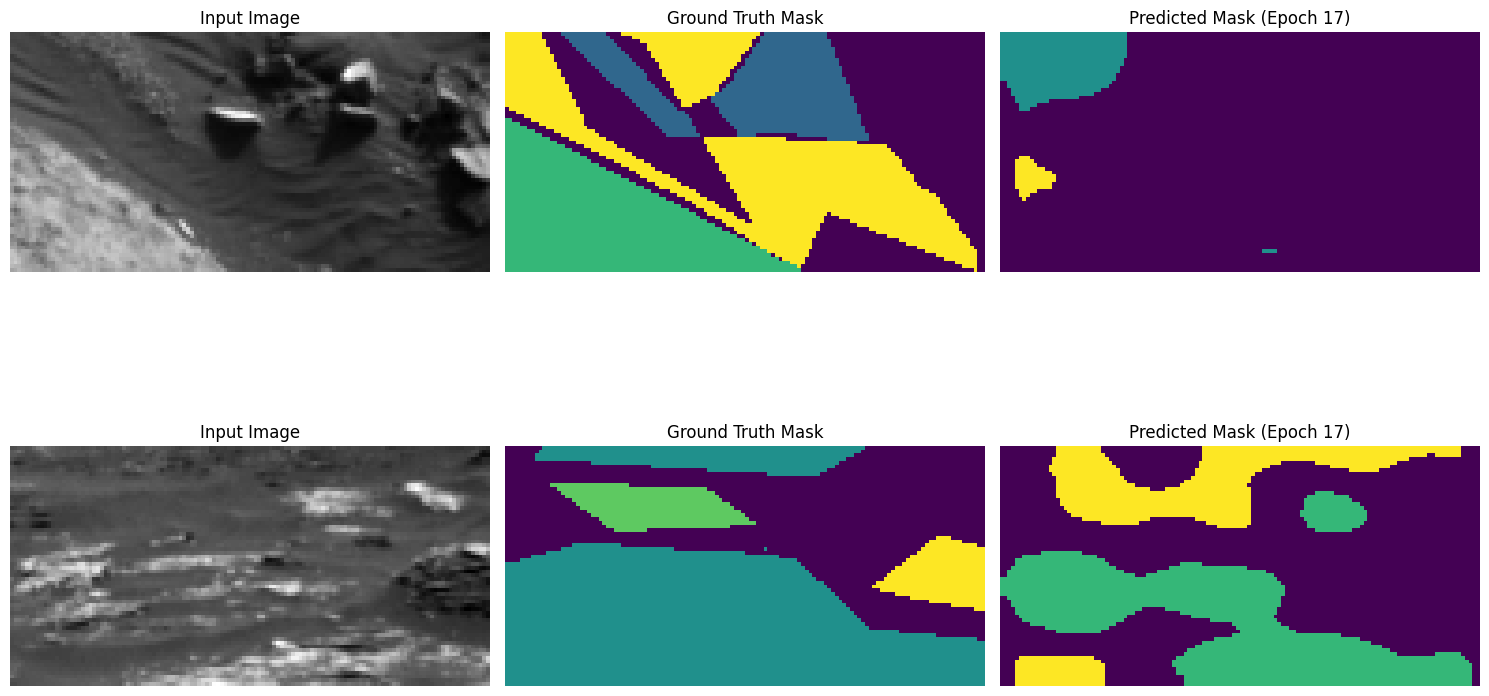

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.8355 - loss: 0.4360 - mean_io_u: 0.5155 - val_accuracy: 0.6019 - val_loss: 1.3146 - val_mean_io_u: 0.2727 - learning_rate: 1.0000e-04
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8543 - loss: 0.3904 - mean_io_u: 0.5342
Epoch 18: val_loss improved from 0.99830 to 0.89276, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


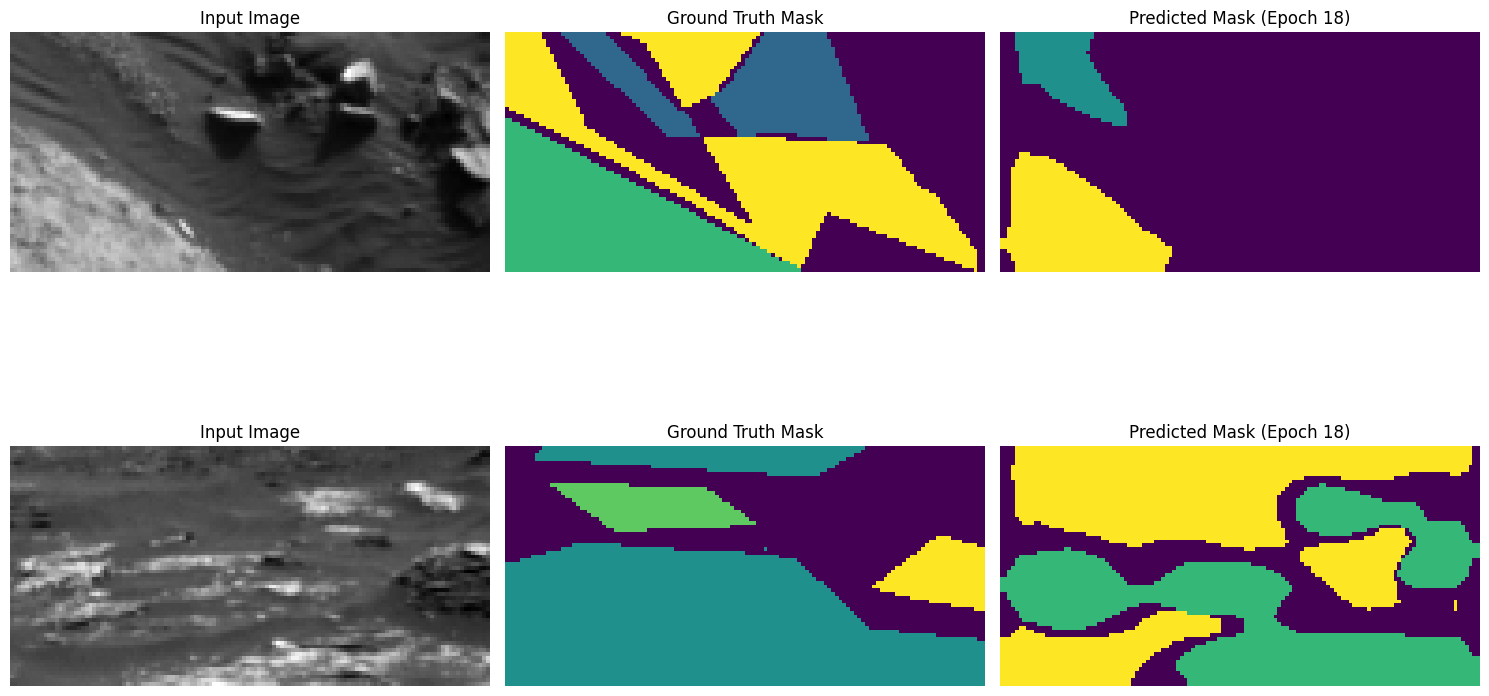

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.8543 - loss: 0.3903 - mean_io_u: 0.5342 - val_accuracy: 0.6718 - val_loss: 0.8928 - val_mean_io_u: 0.3848 - learning_rate: 5.0000e-05
Epoch 19/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8631 - loss: 0.3635 - mean_io_u: 0.5349
Epoch 19: val_loss improved from 0.89276 to 0.81853, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


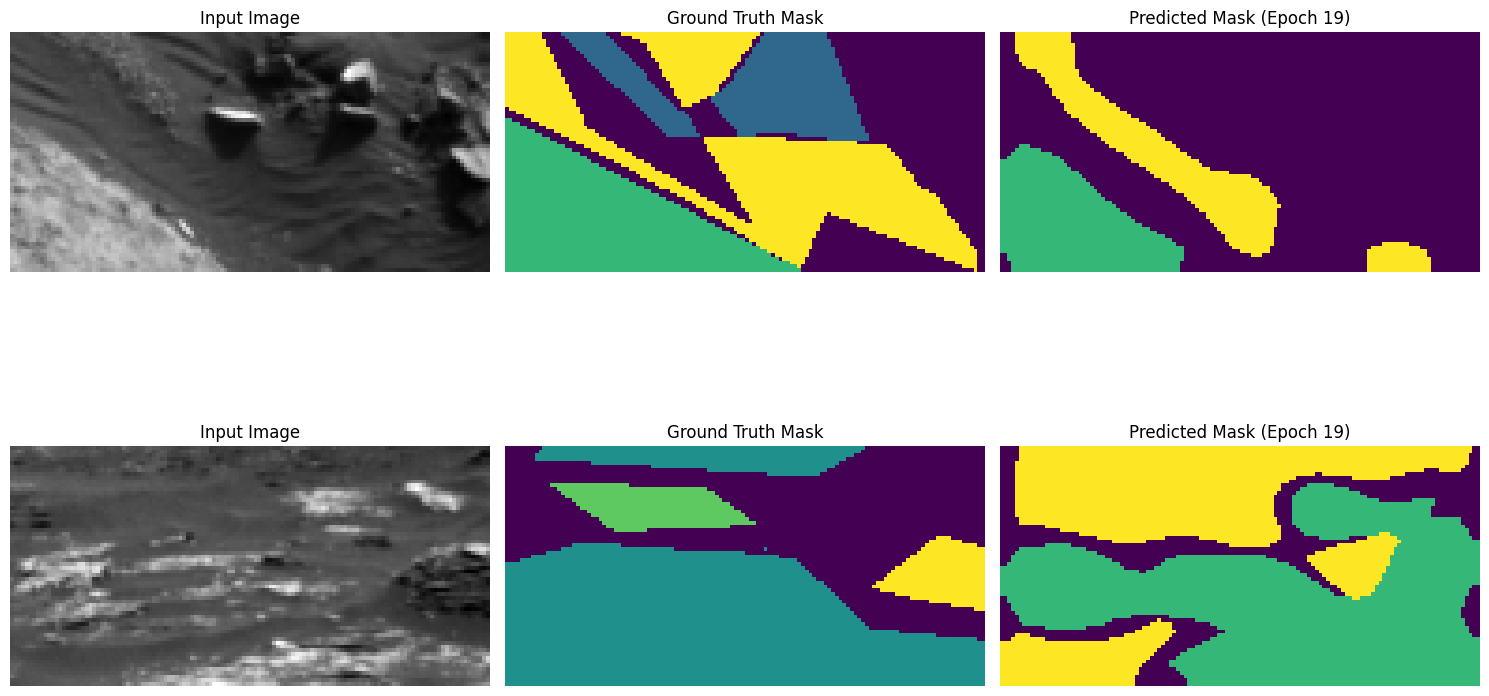

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - accuracy: 0.8631 - loss: 0.3635 - mean_io_u: 0.5348 - val_accuracy: 0.7044 - val_loss: 0.8185 - val_mean_io_u: 0.4203 - learning_rate: 5.0000e-05
Epoch 20/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8638 - loss: 0.3680 - mean_io_u: 0.5395
Epoch 20: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


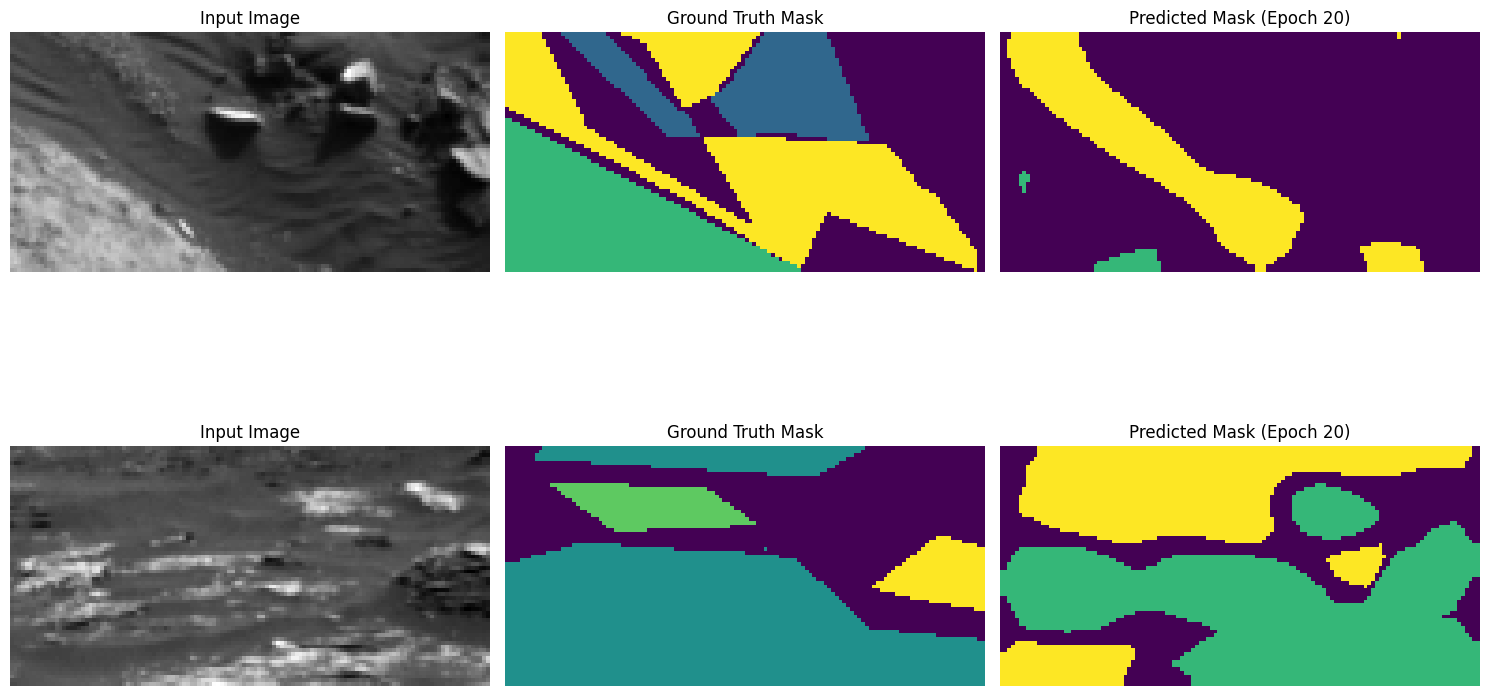

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.8638 - loss: 0.3682 - mean_io_u: 0.5394 - val_accuracy: 0.6904 - val_loss: 0.8748 - val_mean_io_u: 0.3978 - learning_rate: 5.0000e-05
Epoch 21/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8812 - loss: 0.3242 - mean_io_u: 0.5556
Epoch 21: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


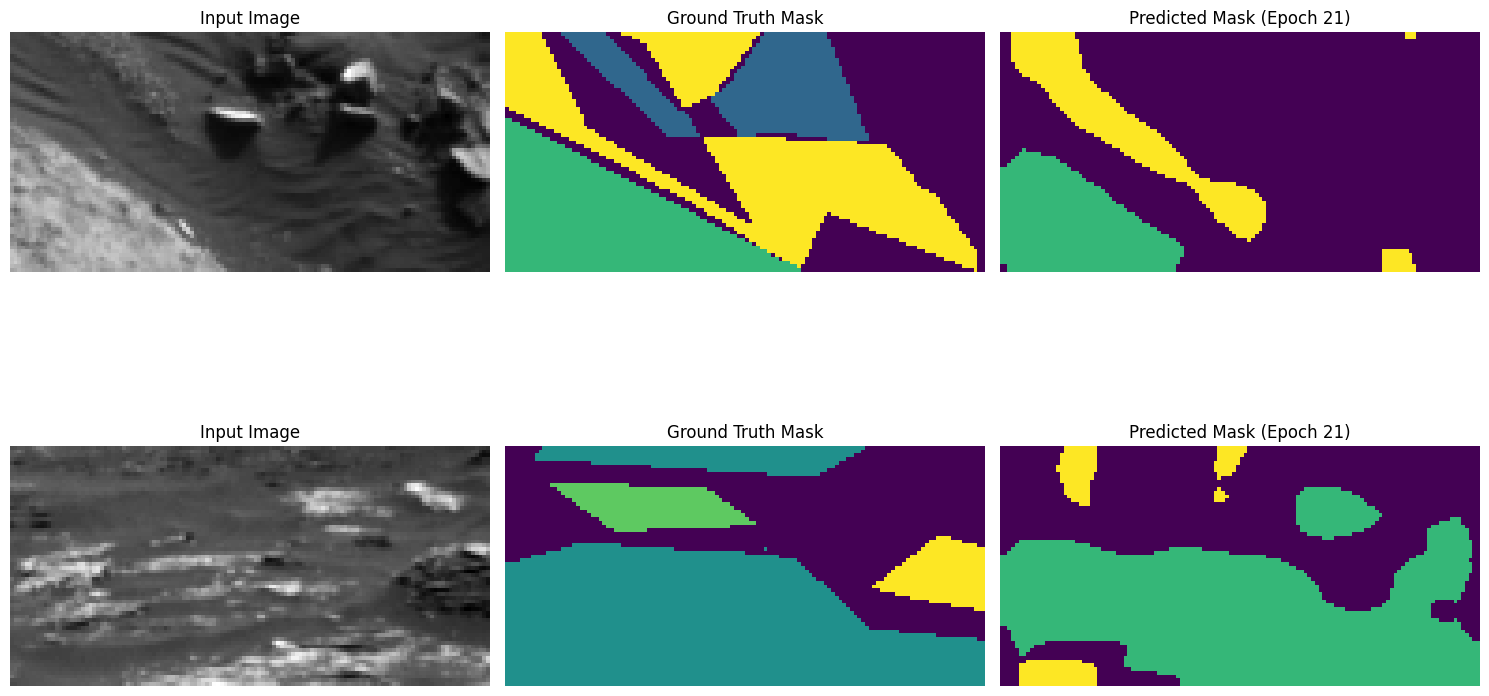

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.8811 - loss: 0.3244 - mean_io_u: 0.5554 - val_accuracy: 0.6974 - val_loss: 0.8425 - val_mean_io_u: 0.4109 - learning_rate: 5.0000e-05
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8809 - loss: 0.3249 - mean_io_u: 0.5578
Epoch 22: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


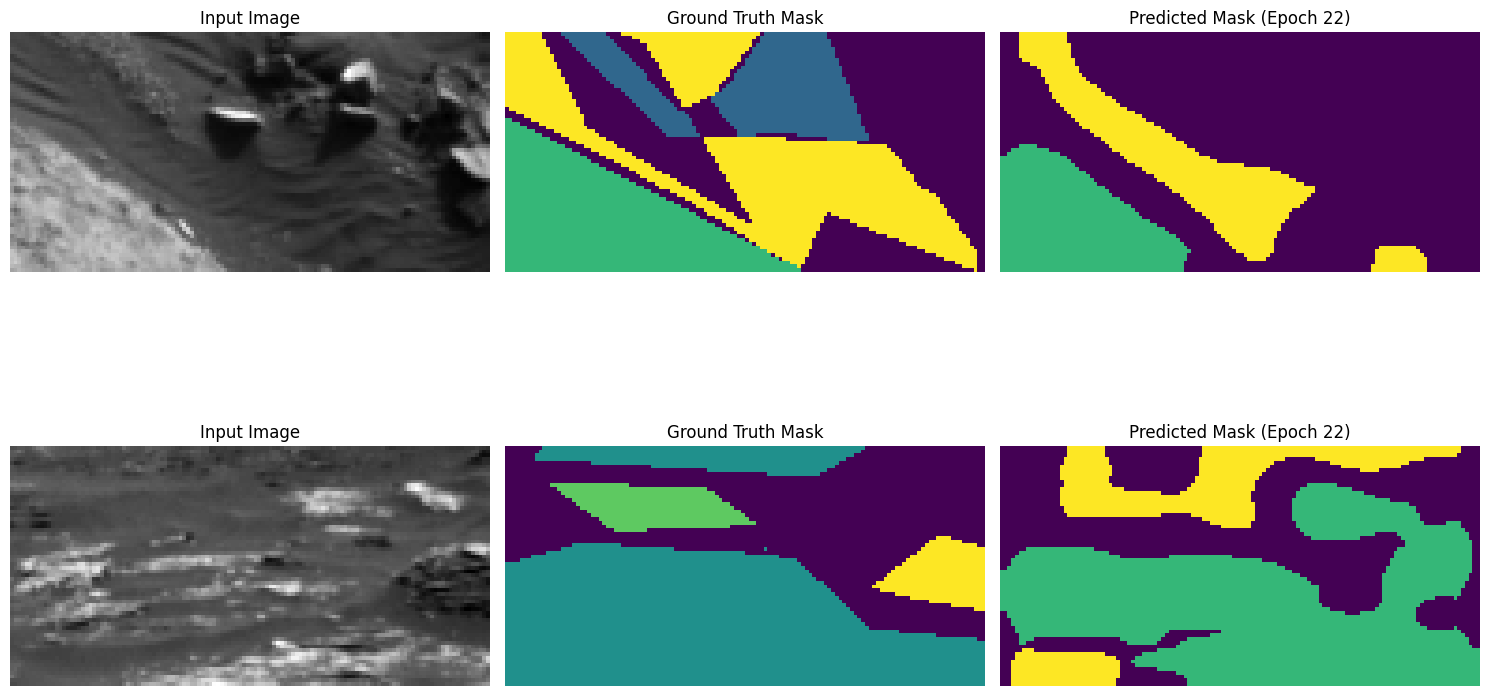

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8809 - loss: 0.3250 - mean_io_u: 0.5577 - val_accuracy: 0.6950 - val_loss: 0.8826 - val_mean_io_u: 0.4083 - learning_rate: 5.0000e-05
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8919 - loss: 0.3014 - mean_io_u: 0.5619
Epoch 23: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


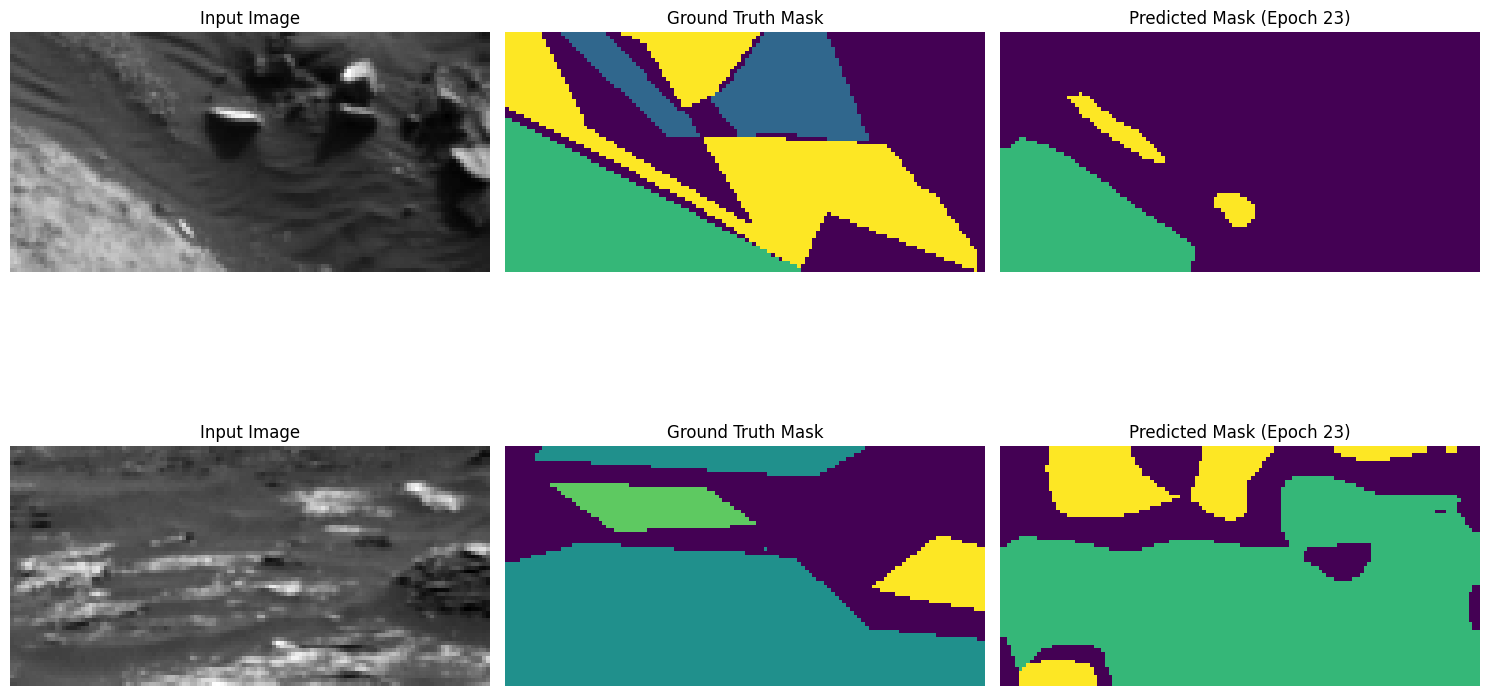

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.8919 - loss: 0.3014 - mean_io_u: 0.5619 - val_accuracy: 0.6776 - val_loss: 0.9441 - val_mean_io_u: 0.3958 - learning_rate: 5.0000e-05
Epoch 24/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8950 - loss: 0.2870 - mean_io_u: 0.5739
Epoch 24: val_loss did not improve from 0.81853

Epoch 24: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


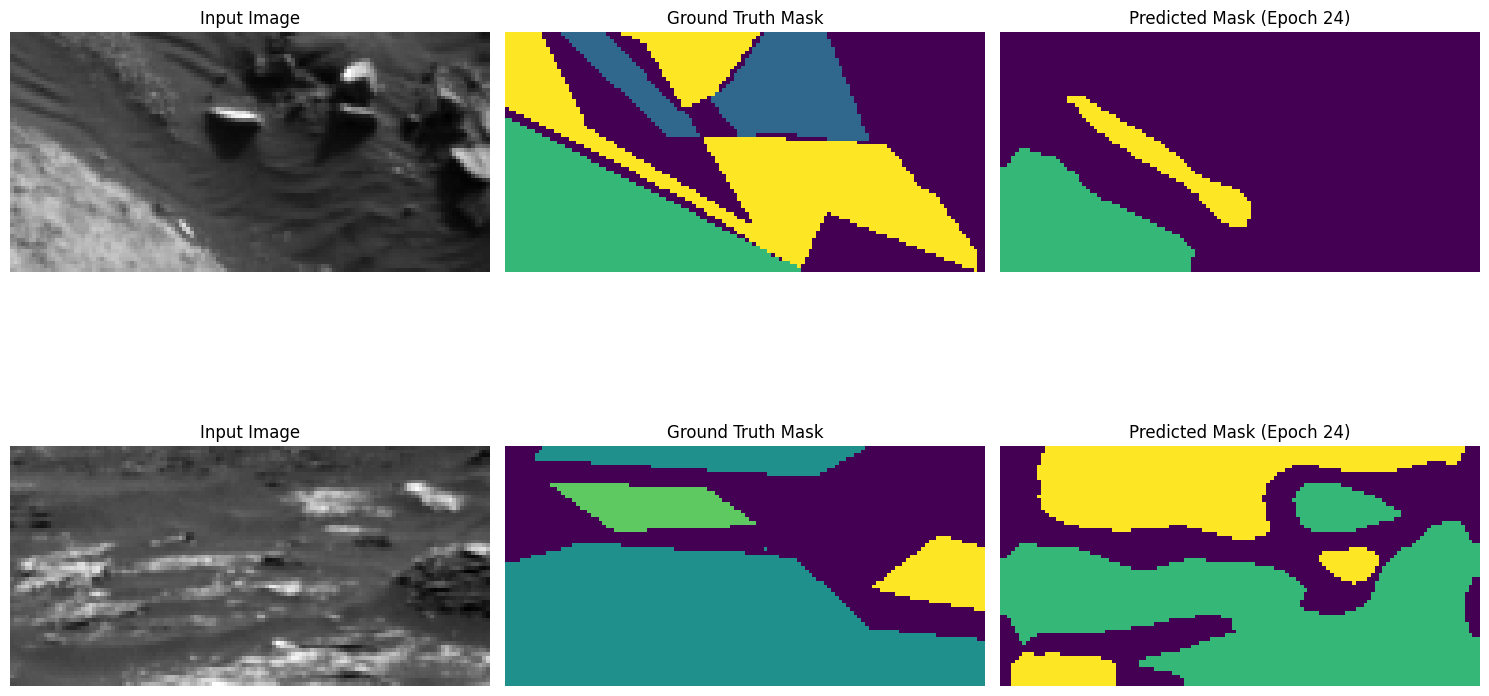

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.8949 - loss: 0.2871 - mean_io_u: 0.5737 - val_accuracy: 0.7087 - val_loss: 0.8578 - val_mean_io_u: 0.4219 - learning_rate: 5.0000e-05
Epoch 25/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9053 - loss: 0.2607 - mean_io_u: 0.5614
Epoch 25: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


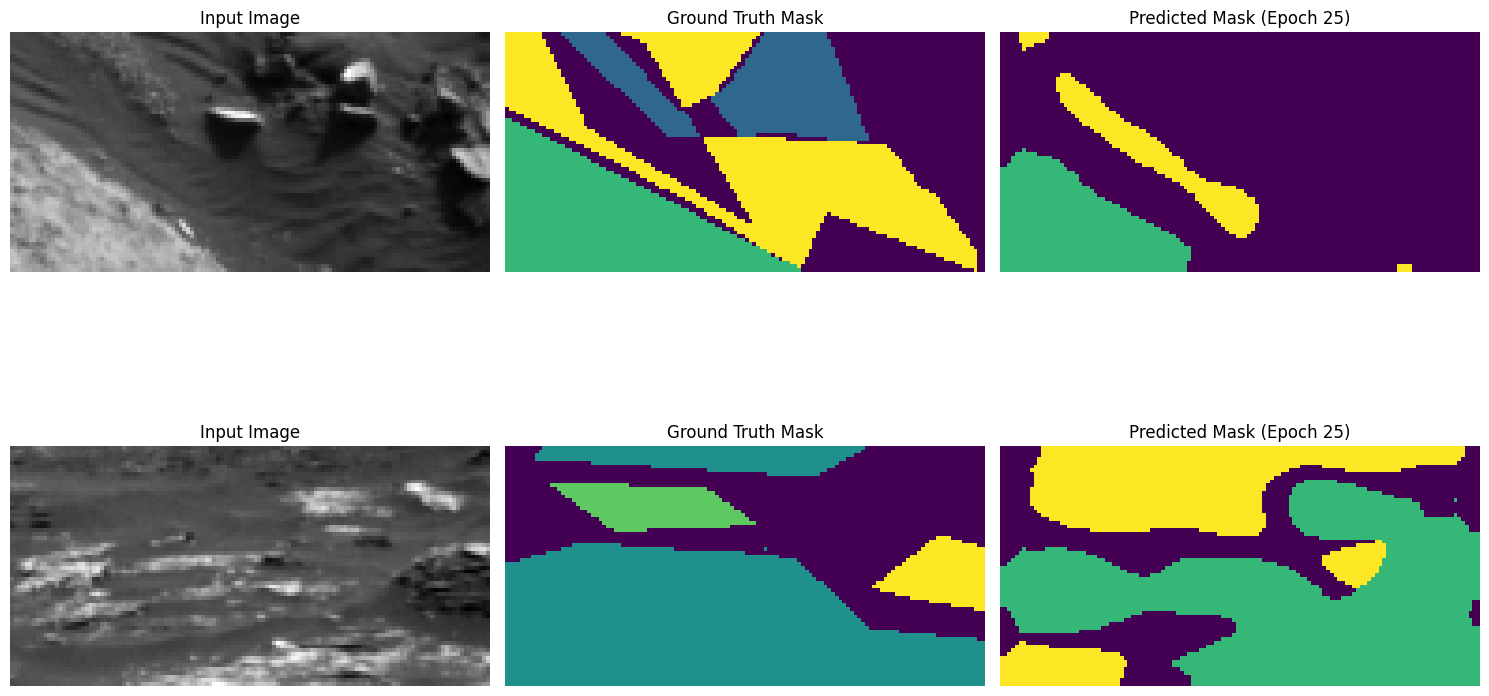

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.9052 - loss: 0.2610 - mean_io_u: 0.5611 - val_accuracy: 0.6802 - val_loss: 0.9356 - val_mean_io_u: 0.3904 - learning_rate: 2.5000e-05
Epoch 26/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9045 - loss: 0.2604 - mean_io_u: 0.5759
Epoch 26: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


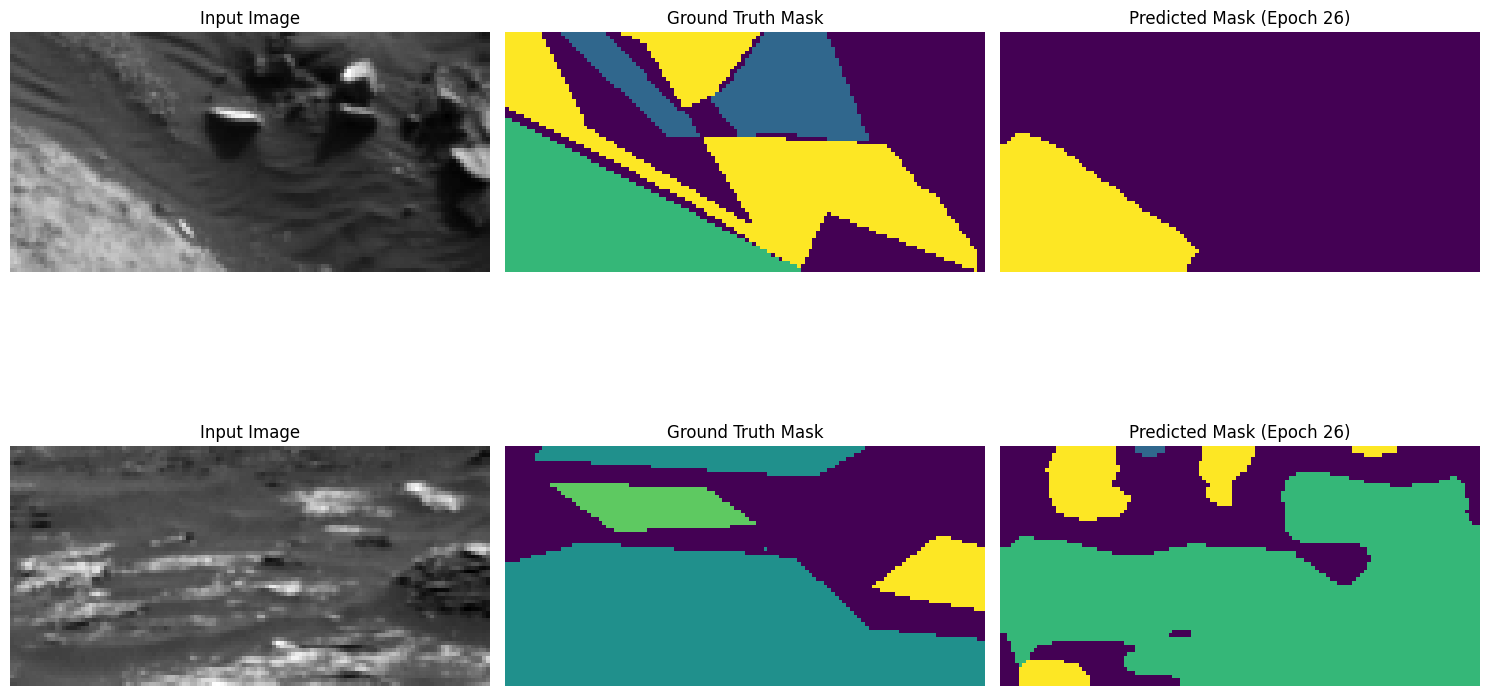

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.9045 - loss: 0.2606 - mean_io_u: 0.5757 - val_accuracy: 0.6903 - val_loss: 0.9389 - val_mean_io_u: 0.3952 - learning_rate: 2.5000e-05
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9106 - loss: 0.2472 - mean_io_u: 0.5853
Epoch 27: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


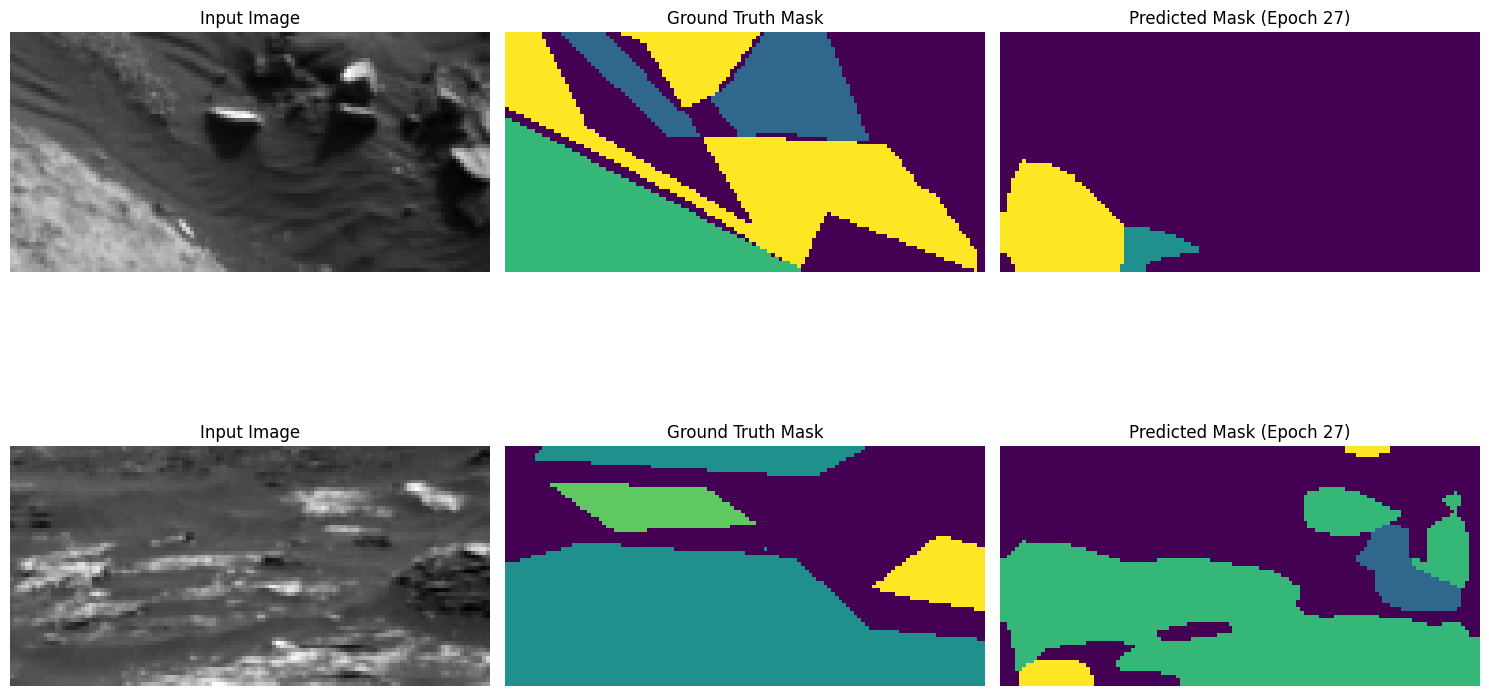

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.9105 - loss: 0.2473 - mean_io_u: 0.5851 - val_accuracy: 0.6794 - val_loss: 1.0087 - val_mean_io_u: 0.3927 - learning_rate: 2.5000e-05
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9120 - loss: 0.2434 - mean_io_u: 0.5806
Epoch 28: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


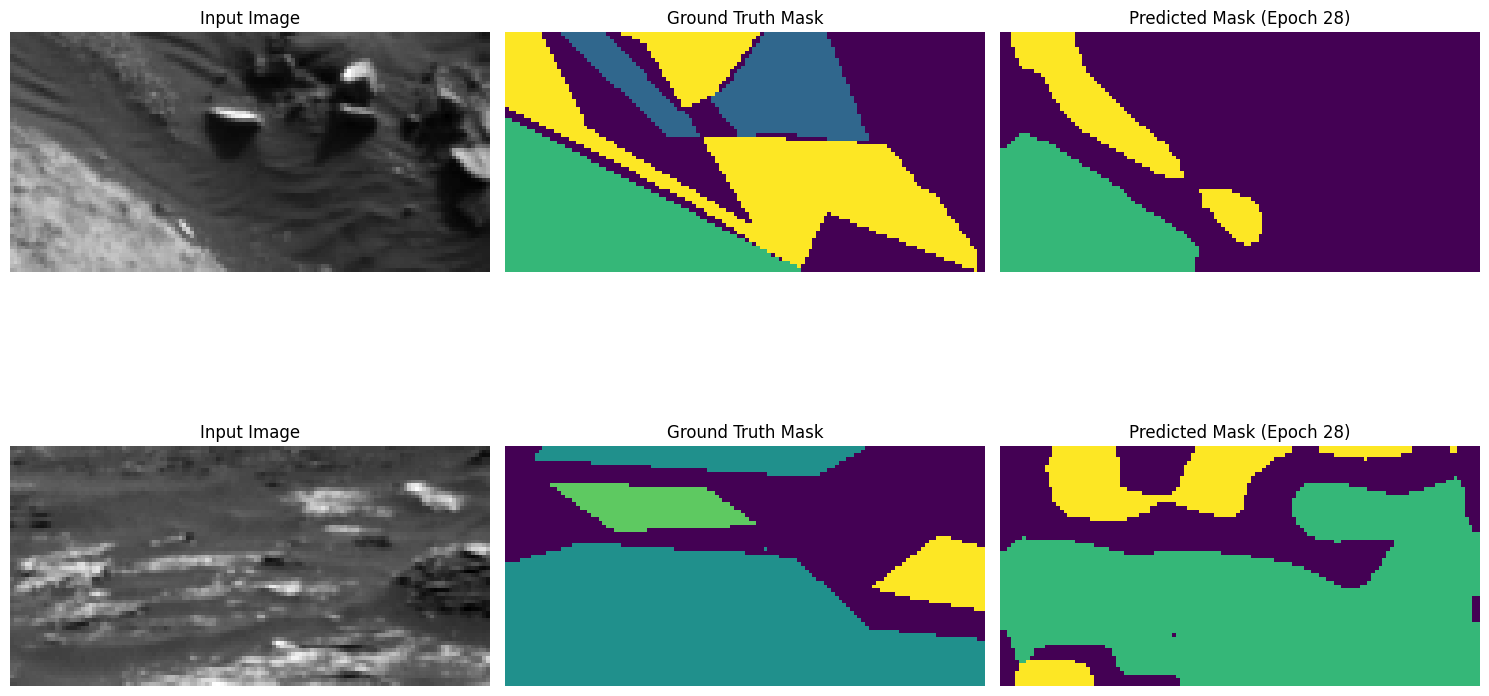

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.9120 - loss: 0.2434 - mean_io_u: 0.5804 - val_accuracy: 0.6660 - val_loss: 1.1072 - val_mean_io_u: 0.3798 - learning_rate: 2.5000e-05
Epoch 29/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9142 - loss: 0.2358 - mean_io_u: 0.5776
Epoch 29: val_loss did not improve from 0.81853

Epoch 29: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


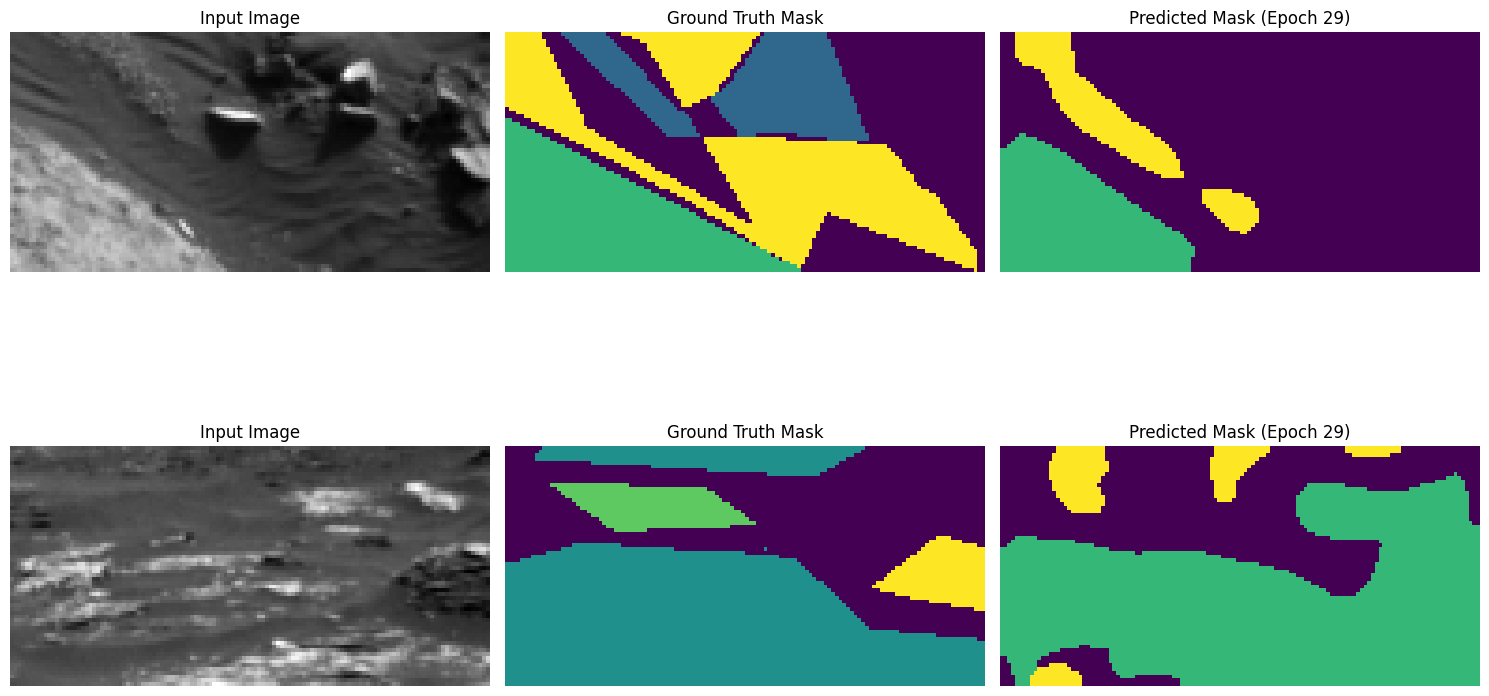

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.9142 - loss: 0.2360 - mean_io_u: 0.5775 - val_accuracy: 0.6844 - val_loss: 1.0077 - val_mean_io_u: 0.4033 - learning_rate: 2.5000e-05
Epoch 30/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9128 - loss: 0.2419 - mean_io_u: 0.5769
Epoch 30: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


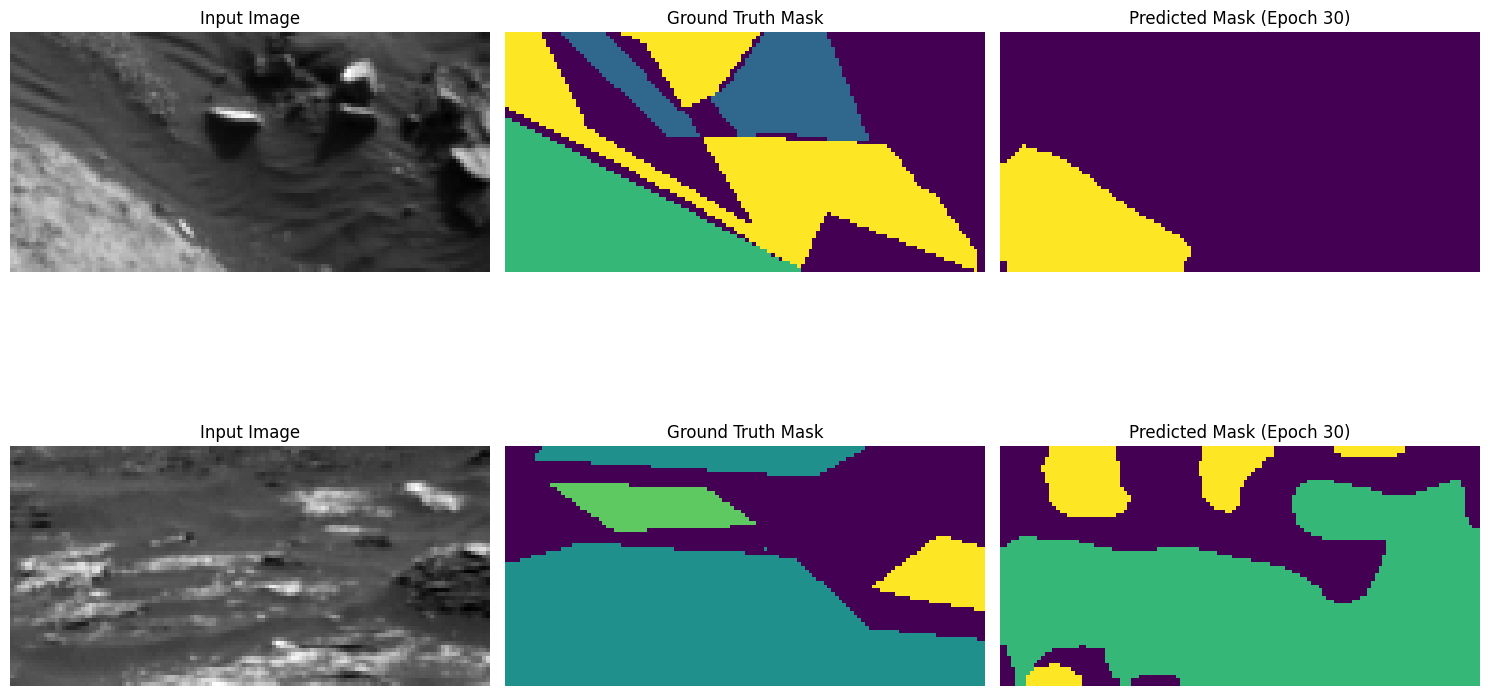

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.9128 - loss: 0.2420 - mean_io_u: 0.5768 - val_accuracy: 0.7097 - val_loss: 0.9409 - val_mean_io_u: 0.4257 - learning_rate: 1.2500e-05
Epoch 31/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9176 - loss: 0.2277 - mean_io_u: 0.5767
Epoch 31: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


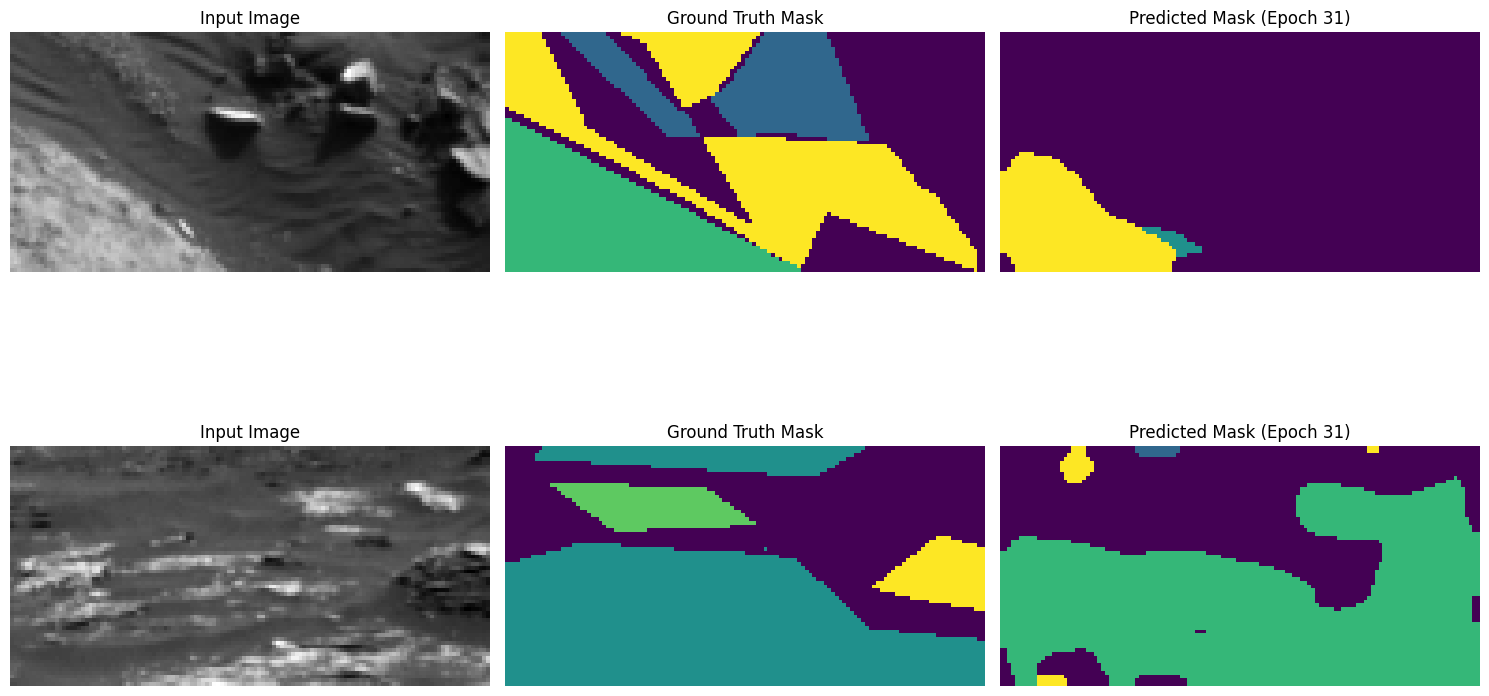

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.9176 - loss: 0.2277 - mean_io_u: 0.5767 - val_accuracy: 0.7172 - val_loss: 0.9005 - val_mean_io_u: 0.4336 - learning_rate: 1.2500e-05
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9218 - loss: 0.2192 - mean_io_u: 0.5880
Epoch 32: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


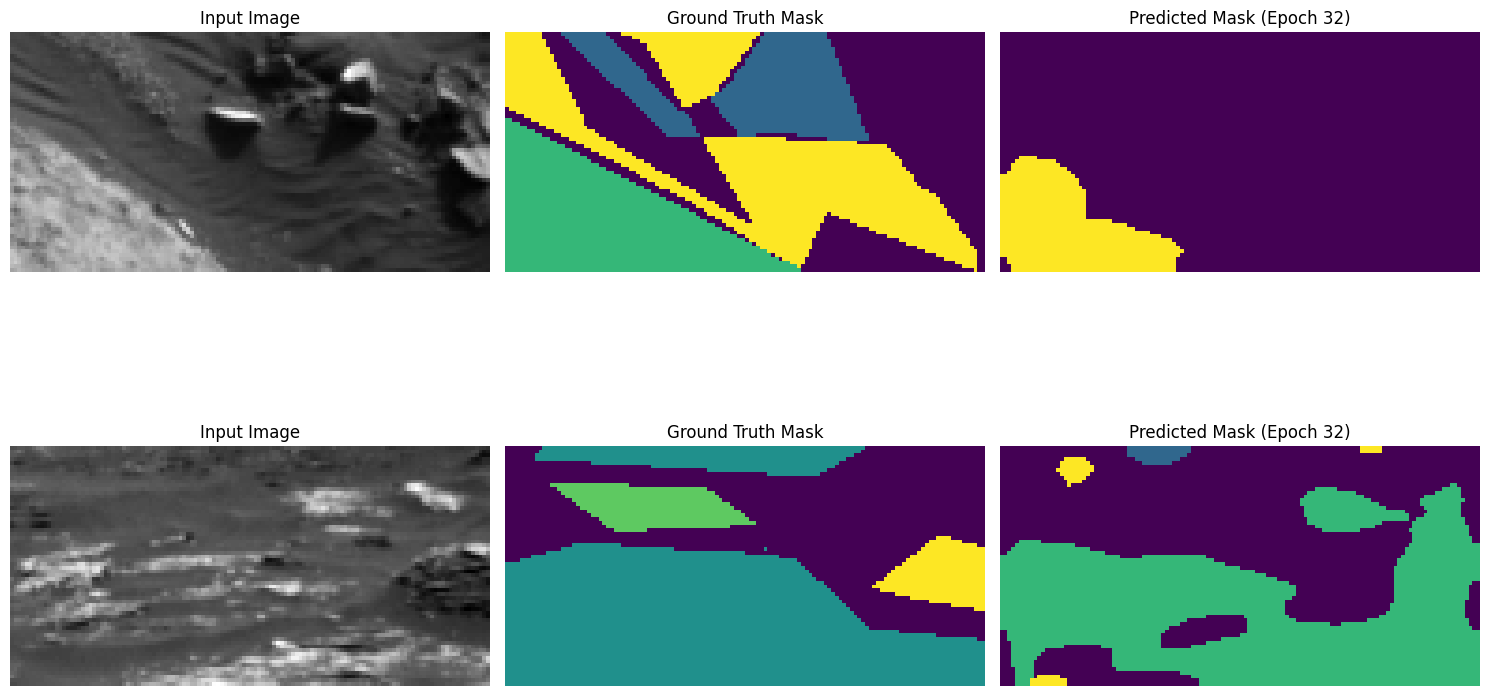

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.9217 - loss: 0.2193 - mean_io_u: 0.5879 - val_accuracy: 0.7136 - val_loss: 0.9072 - val_mean_io_u: 0.4325 - learning_rate: 1.2500e-05
Epoch 33/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9213 - loss: 0.2174 - mean_io_u: 0.5861
Epoch 33: val_loss did not improve from 0.81853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


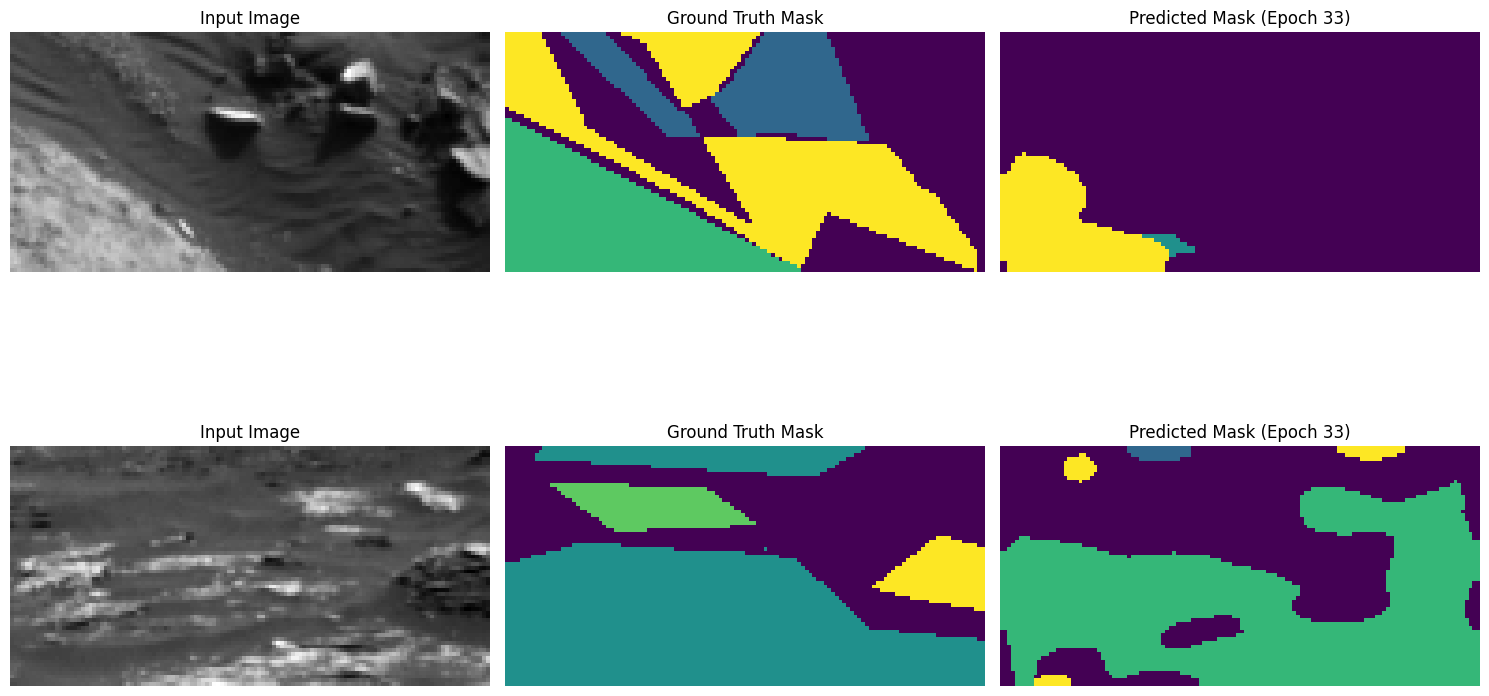

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9213 - loss: 0.2173 - mean_io_u: 0.5861 - val_accuracy: 0.7105 - val_loss: 0.9296 - val_mean_io_u: 0.4294 - learning_rate: 1.2500e-05
Epoch 34/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9269 - loss: 0.2037 - mean_io_u: 0.5847
Epoch 34: val_loss did not improve from 0.81853

Epoch 34: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


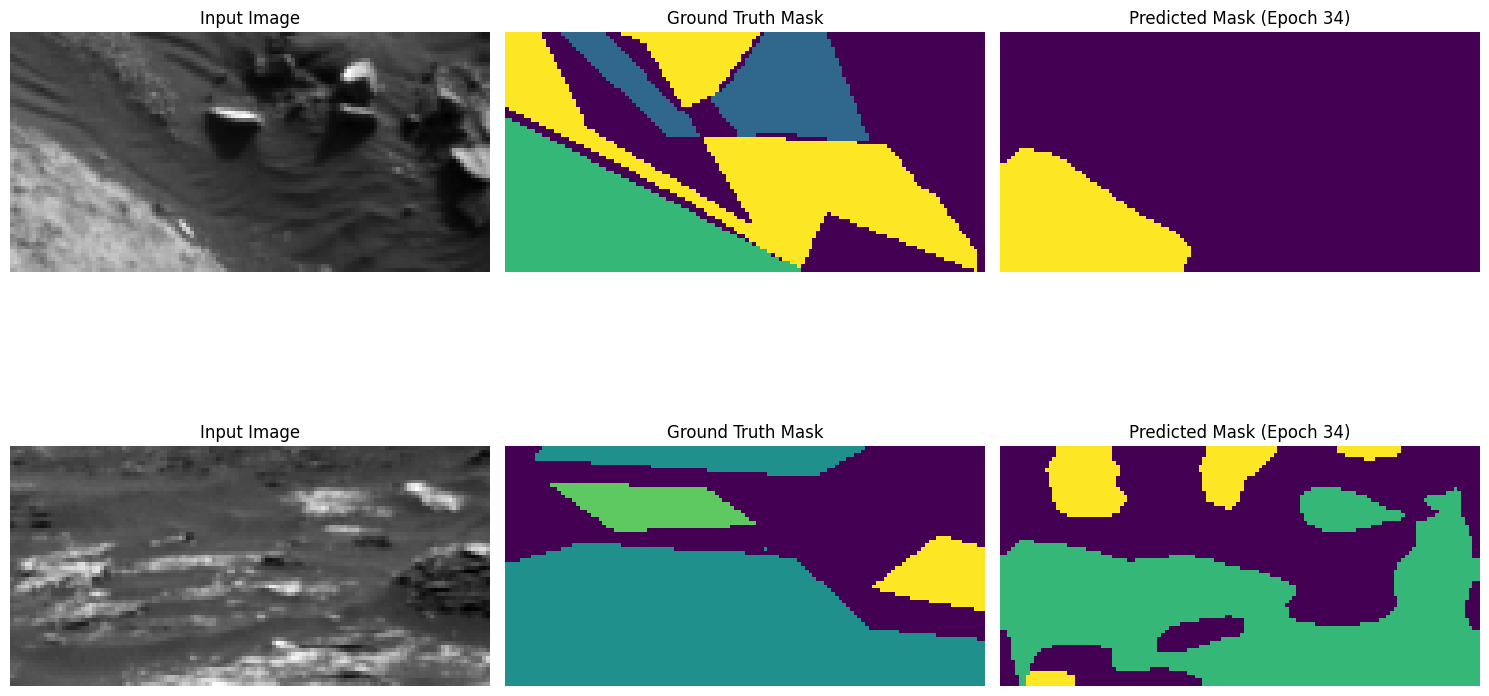

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.9269 - loss: 0.2038 - mean_io_u: 0.5847 - val_accuracy: 0.7122 - val_loss: 0.9159 - val_mean_io_u: 0.4233 - learning_rate: 1.2500e-05


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)

model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


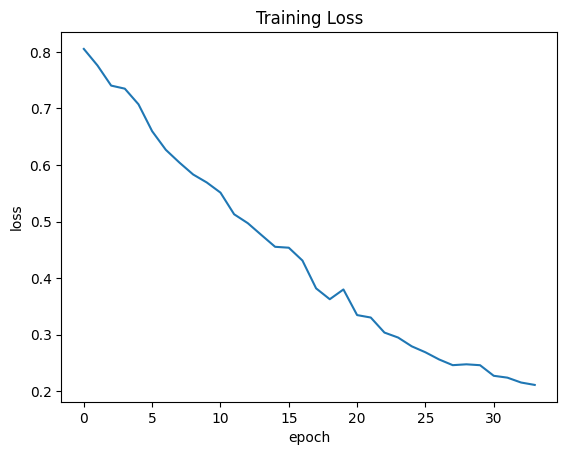

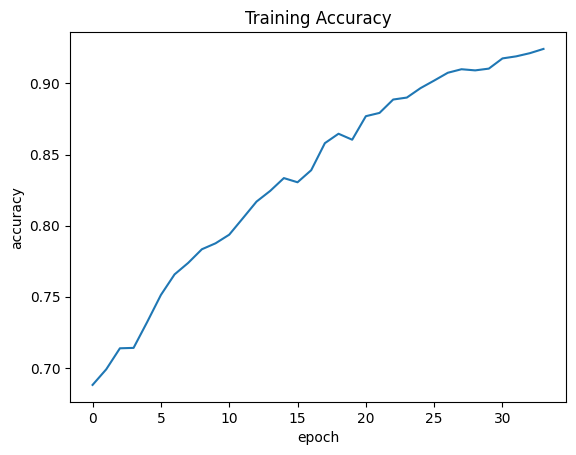

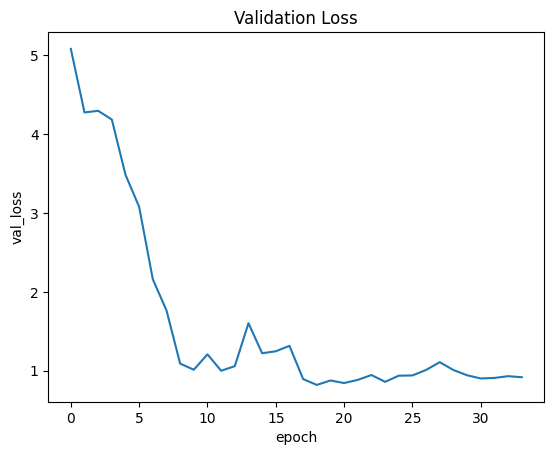

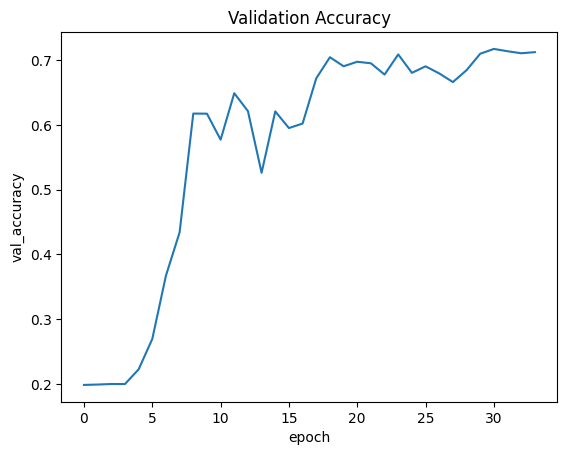

In [36]:


plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [37]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_model.keras")

# Print the summary to verify
best_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 134, 1)     │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 64, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 35,475,857 (135.33 MB)

 Trainable params: 11,814,373 (45.07 MB)

 Non-trainable params: 32,736 (127.88 KB)

 Optimizer params: 23,628,748 (90.14 MB)

In [38]:
model_filename = f"deeplab.keras"
best_model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to deeplab.keras


In [39]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [40]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [41]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


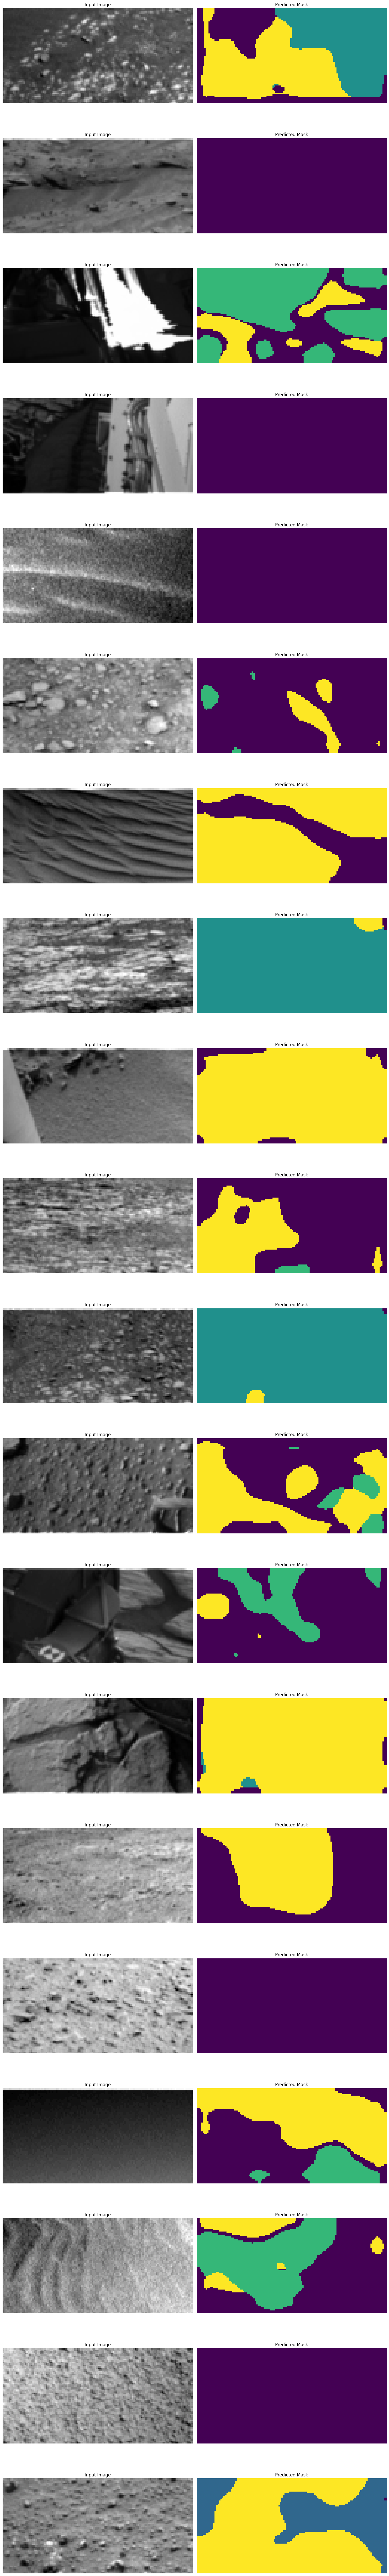

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [43]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [44]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>